In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
import pandas as pd
import torch.nn as nn
import os
import json

from utils.dataloader  import FaceDataset, preprocess, postprocess
from utils.learning import testing, training, scores
from utils.utils_data import train_validation_test_split
from utils.visiualisation import display_graph_learning, grid_image_data_set
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from models.resnet import ResnetCustomModel
from tqdm import tqdm
from collections import OrderedDict
from json import JSONEncoder

torch.cuda.empty_cache()

## Classification Resnet Custom

### Telechargement et Visualisation de notre jeu de donnée

In [2]:
faceDataset = FaceDataset(preprocess(), is_classification=True)
print(f'Taille du dataset: {len(faceDataset)}')

Taille du dataset: 43266


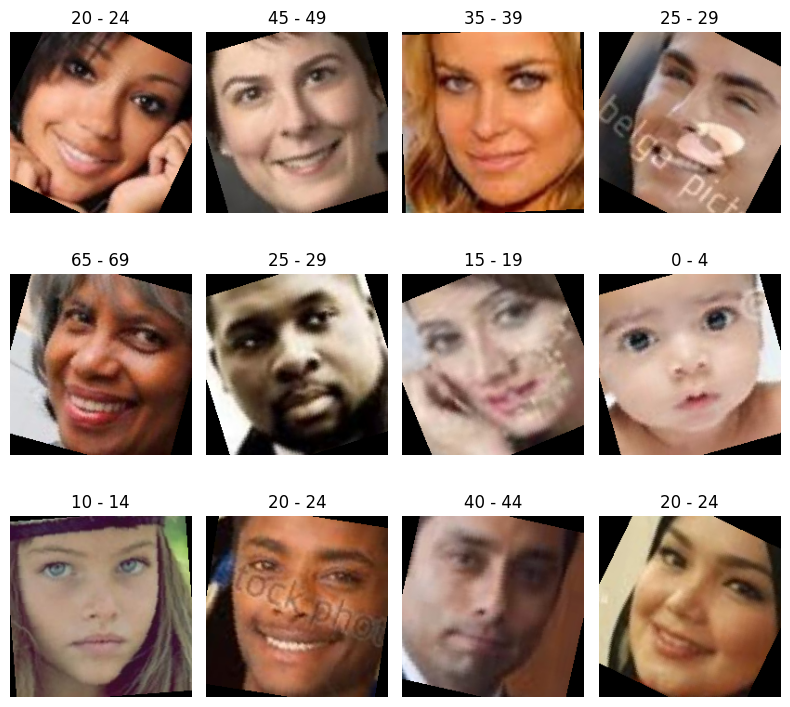

In [3]:
fig, ax = plt.subplots(3, 4, tight_layout=True, figsize=(8, 8))

label_names = faceDataset.get_all_age_range()

for i in range(3):
    for j in range(4):
        rand_idx = np.random.randint(0, len(faceDataset))
        img, label = faceDataset[rand_idx]
        postprocess_apply = postprocess()
        ax[i,j].imshow(postprocess_apply(img))
        ax[i,j].set_title(label_names[label])
        ax[i,j].set_axis_off()
        

##### Visualisation de la distribution des données

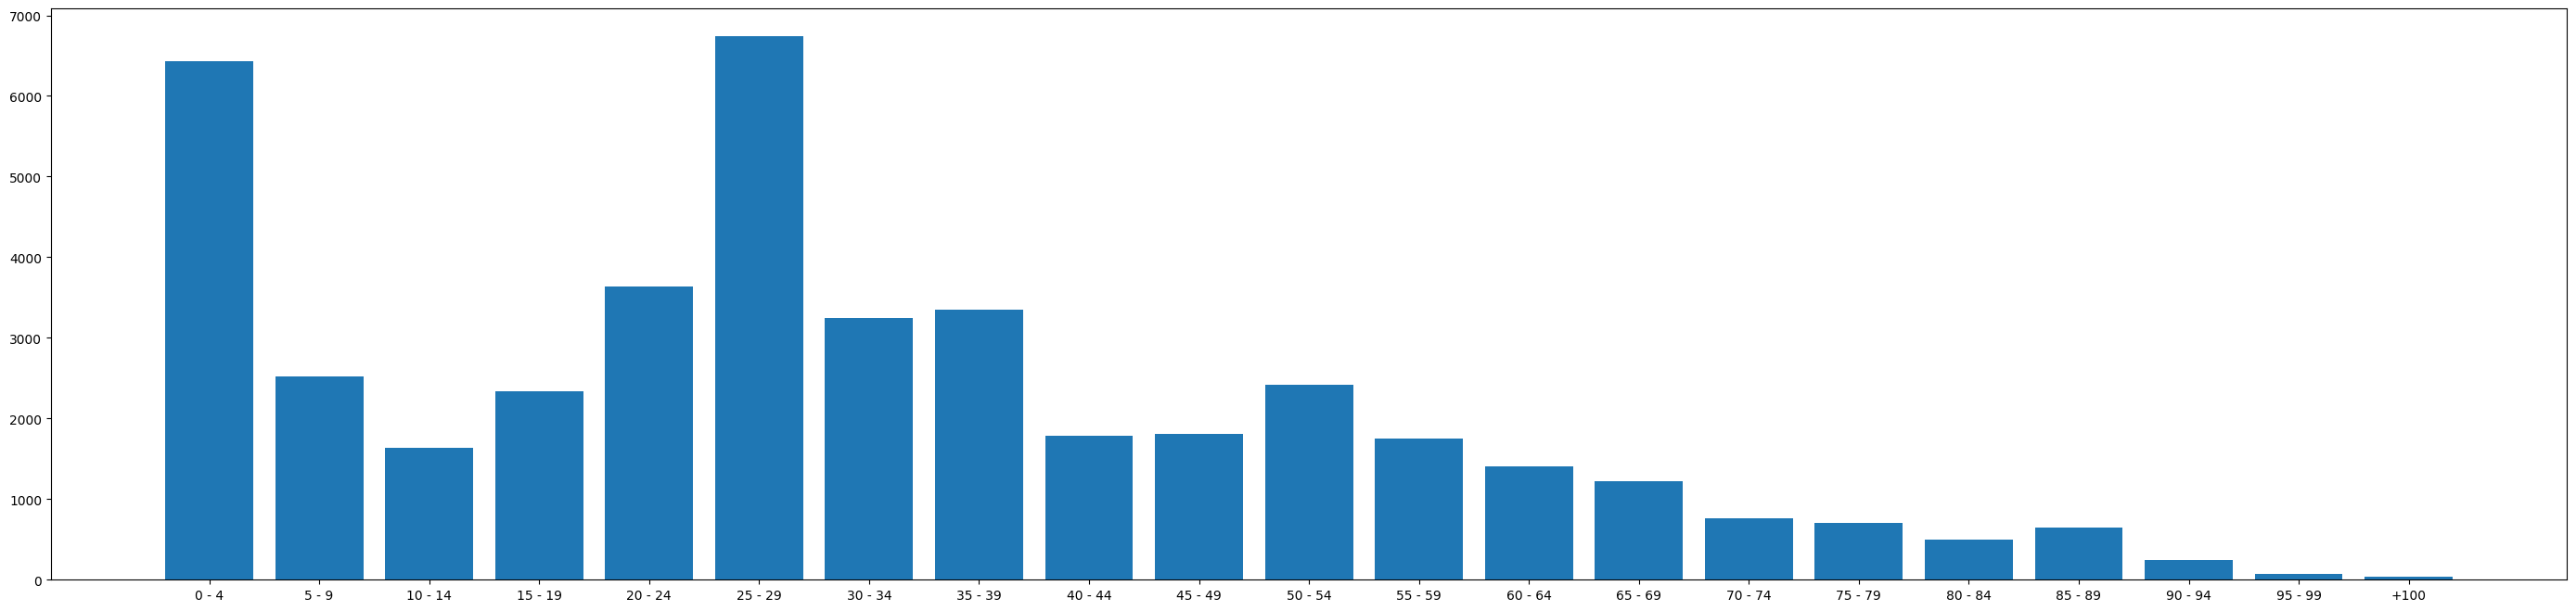

In [4]:
img_by_age_range = faceDataset.img_labels.groupby(['age_range'])['age_range']
df = img_by_age_range.count()

fig, ax = plt.subplots(figsize=(35, 8))
bar_container = ax.bar(label_names.values(), df.values)


## Regression Resnet Custom

In [2]:
faceDataset = FaceDataset(preprocess(), is_classification=False)

### Split dataset train, validation et test

In [5]:
train_sampler, validation_sampler, test_sampler = train_validation_test_split(faceDataset, test_size=0.2)

### Initialisation premiere couche
Intuitions:
- Initialisation des poids pour facilite convergence
- Pseudo copie de transfert de style avec architecture VGG ou le poids des couches relu_1 et relu_2 corresponds au style = (Image Style Transfer Using Convolutional Neural Networks) https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf

- Réseau comme feature extraction
- Une autre facon de pouvoir rendre notre reseau robuste en essayant de facon intuitive de capturer la representation d'un visage en fonction de son group d'age idée inspirer de la methode de regression de cette article Moving Window Regression: A Novel Approach to Ordinal Regression  (https://arxiv.org/pdf/2203.13122v1.pdf), qui a consiste a mettre en place une methode de regression avec par fenetre permettant de d'adapter la prediction en fonction des groupe d'age
- Idee tester et ratter c'etait de geneler la couche pretrain, mais apres un apprentissage sur 50 epochs pour vois si le reseau apprend nous constatons que cela ne fonctionne pas. 


In [3]:
vgg_range_09 = torch.load('models/custom_vgg_09.pt')
vgg_range_1019 = torch.load('models/custom_vgg_1019.pt')
vgg_range_2044 = torch.load('models/custom_vgg_2044.pt')
vgg_range_45 = torch.load('models/custom_vgg_45.pt')

conv2 = torch.empty((64, 64, 3, 3))

conv1 = torch.cat((vgg_range_09.conv1_a.weight.data, vgg_range_1019.conv1_a.weight.data, vgg_range_2044.conv1_a.weight.data, vgg_range_45.conv1_a.weight.data))
bn1 = torch.cat((vgg_range_09.bn1_a.weight.data, vgg_range_1019.bn1_a.weight.data, vgg_range_2044.bn1_a.weight.data, vgg_range_45.bn1_a.weight.data))
conv2[:, :16, :] = torch.cat((vgg_range_09.conv1_b.weight.data, vgg_range_1019.conv1_b.weight.data, vgg_range_2044.conv1_b.weight.data, vgg_range_45.conv1_b.weight.data))
bn2 = torch.cat((vgg_range_09.bn1_b.weight.data, vgg_range_1019.bn1_b.weight.data, vgg_range_2044.bn1_b.weight.data, vgg_range_45.bn1_b.weight.data))

pretrain = nn.Sequential(OrderedDict(
                [
                    ('conv-00', nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)),
                    ('bash-00', nn.BatchNorm2d(64)),
                    ('conv-01', nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)),
                    ('bash-01', nn.BatchNorm2d(64)),
                    ('relu-01', nn.ReLU(inplace=True)),
                ]
            )
        )

with torch.no_grad():
    pretrain[0].weight.data = conv1
    pretrain[1].weight.data = bn1
    pretrain[2].weight.data = conv2
    pretrain[3].weight.data = bn2

# empty memory
del vgg_range_09
del vgg_range_1019
del vgg_range_2044
del vgg_range_45
del conv2
del conv1
del bn1
del bn2

### Entrainement

#### Pour l'hypothese de feature representation, nous  gele la couche de represenation vgg. Voir si le gradient descent 

In [8]:
# make ce
batch_size=32
learning_rate=1e-4


criterion = nn.MSELoss()

model_freeze_pretrain = ResnetCustomModel(pretrain=pretrain, is_freeze_pretrain=True)

optimizer = Adam(params=model_freeze_pretrain.parameters(), lr=learning_rate)


train_loader = DataLoader(faceDataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(faceDataset, batch_size=batch_size, sampler=test_sampler)


model_freeze_pretrain, hist_train_loss_model_freeze, _ = training(model_freeze_pretrain, 6, criterion=criterion, optimizer=optimizer, 
                                                    train_loader=train_loader, 
                                                    full_train=True,
                                                    do_save=False,
                                                    DEVICE='cuda')

Training process epoch 1/6


100%|██████████| 1082/1082 [07:36<00:00,  2.37it/s]


[-] epoch 1/6, train loss 228.201002
 
Training process epoch 2/6


100%|██████████| 1082/1082 [07:02<00:00,  2.56it/s]


[-] epoch 2/6, train loss 134.782544
 
Training process epoch 3/6


100%|██████████| 1082/1082 [07:06<00:00,  2.54it/s]


[-] epoch 3/6, train loss 110.461481
 
Training process epoch 4/6


100%|██████████| 1082/1082 [07:14<00:00,  2.49it/s]


[-] epoch 4/6, train loss 95.361961
 
Training process epoch 5/6


100%|██████████| 1082/1082 [07:37<00:00,  2.37it/s]


[-] epoch 5/6, train loss 82.427363
 
Training process epoch 6/6


100%|██████████| 1082/1082 [07:44<00:00,  2.33it/s]

[-] epoch 6/6, train loss 72.570034
 


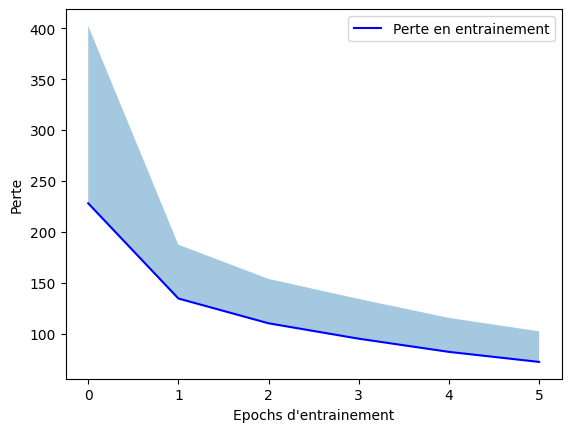

<Figure size 640x480 with 0 Axes>

In [15]:
x = np.arange(0, len(hist_train_loss_model_freeze[:, 0]))

plt.plot(x, hist_train_loss_model_freeze[:, 0], color='blue', label='Perte en entrainement')
plt.fill_between(x, hist_train_loss_model_freeze[:, 0], hist_train_loss_model_freeze[:, 0]+hist_train_loss_model_freeze[:, 1], alpha=0.4)

plt.xlabel("Epochs d'entrainement")
plt.ylabel("Perte")

plt.legend()

plt.show()

plt.savefig(f'see_if_method_learn.jpg')

Nous constatons que nous avons une diminution du gradient donc notre hypothese est correct

#### Determinons le nombre d'epochs que nous pouvons utilise pour entrainer notre mode

In [4]:
train_sampler, validation_sampler, test_sampler = train_validation_test_split(faceDataset, validation_size=0.2, test_size=0.2)

In [5]:
# make ce
batch_size=32
learning_rate=1e-4


criterion = nn.MSELoss()

model_verify = ResnetCustomModel()

optimizer = Adam(params=model_verify.parameters(), lr=learning_rate)


train_loader = DataLoader(faceDataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = DataLoader(faceDataset, batch_size=batch_size, sampler=validation_sampler)
test_loader = DataLoader(faceDataset, batch_size=batch_size, sampler=test_sampler)


model_verify, hist_train_loss, hist_val_loss, _ = training(model_verify, 200, criterion=criterion, optimizer=optimizer, 
                                                    train_loader=train_loader, 
                                                    validation_loader=validation_loader, 
                                                    patient=0, best_save=True, do_save=True, 
                                                    file_name=f'resnet_custom_verify', 
                                                    DEVICE='cuda')

Training process epoch 1/200


100%|██████████| 866/866 [06:37<00:00,  2.18it/s]


Test process 1/200


100%|██████████| 217/217 [00:45<00:00,  4.81it/s]


[-] epoch 1/200, train loss 255.895880, valiation loss 153.274050, socres => MAE: 8.929933545218145, R2 0.6970673945193953
 
[-] epoch 1/200, train loss 255.895880
 
Training process epoch 2/200


100%|██████████| 866/866 [06:04<00:00,  2.38it/s]


Test process 2/200


100%|██████████| 217/217 [00:39<00:00,  5.43it/s]


[-] epoch 2/200, train loss 149.916265, valiation loss 119.674338, socres => MAE: 7.9136087835885585, R2 0.7637718183263142
 
[-] epoch 2/200, train loss 149.916265
 
Training process epoch 3/200


100%|██████████| 866/866 [06:00<00:00,  2.40it/s]


Test process 3/200


100%|██████████| 217/217 [00:39<00:00,  5.49it/s]


[-] epoch 3/200, train loss 127.436162, valiation loss 106.652938, socres => MAE: 7.464461138399306, R2 0.7891092239436959
 
[-] epoch 3/200, train loss 127.436162
 
Training process epoch 4/200


100%|██████████| 866/866 [06:00<00:00,  2.40it/s]


Test process 4/200


100%|██████████| 217/217 [00:39<00:00,  5.51it/s]


[-] epoch 4/200, train loss 113.671462, valiation loss 109.979551, socres => MAE: 7.523114706732159, R2 0.7823186543210233
 
[-] epoch 4/200, train loss 113.671462
 
Training process epoch 5/200


100%|██████████| 866/866 [06:01<00:00,  2.40it/s]


Test process 5/200


100%|██████████| 217/217 [00:39<00:00,  5.51it/s]


[-] epoch 5/200, train loss 97.522097, valiation loss 100.697782, socres => MAE: 7.024270442068766, R2 0.8010012788865774
 
[-] epoch 5/200, train loss 97.522097
 
Training process epoch 6/200


100%|██████████| 866/866 [06:10<00:00,  2.34it/s]


Test process 6/200


100%|██████████| 217/217 [00:43<00:00,  4.94it/s]


[-] epoch 6/200, train loss 89.118022, valiation loss 77.050259, socres => MAE: 6.239092747760763, R2 0.8475707680141368
 
[-] epoch 6/200, train loss 89.118022
 
Training process epoch 7/200


100%|██████████| 866/866 [06:19<00:00,  2.28it/s]


Test process 7/200


100%|██████████| 217/217 [00:41<00:00,  5.19it/s]


[-] epoch 7/200, train loss 82.933816, valiation loss 77.789372, socres => MAE: 6.549407685639989, R2 0.8465911504673271
 
[-] epoch 7/200, train loss 82.933816
 
Training process epoch 8/200


100%|██████████| 866/866 [06:16<00:00,  2.30it/s]


Test process 8/200


100%|██████████| 217/217 [00:44<00:00,  4.88it/s]


[-] epoch 8/200, train loss 76.902937, valiation loss 70.408065, socres => MAE: 5.926466339208321, R2 0.860786761522756
 
[-] epoch 8/200, train loss 76.902937
 
Training process epoch 9/200


100%|██████████| 866/866 [06:15<00:00,  2.31it/s]


Test process 9/200


100%|██████████| 217/217 [00:42<00:00,  5.13it/s]


[-] epoch 9/200, train loss 68.892187, valiation loss 68.505127, socres => MAE: 5.898584224212655, R2 0.8644025601266618
 
[-] epoch 9/200, train loss 68.892187
 
Training process epoch 10/200


100%|██████████| 866/866 [06:17<00:00,  2.29it/s]


Test process 10/200


100%|██████████| 217/217 [00:42<00:00,  5.15it/s]


[-] epoch 10/200, train loss 63.842421, valiation loss 68.774021, socres => MAE: 5.7463160936145625, R2 0.8638360136945233
 
[-] epoch 10/200, train loss 63.842421
 
Training process epoch 11/200


100%|██████████| 866/866 [06:13<00:00,  2.32it/s]


Test process 11/200


100%|██████████| 217/217 [00:42<00:00,  5.12it/s]


[-] epoch 11/200, train loss 60.716194, valiation loss 68.425720, socres => MAE: 5.812481941635365, R2 0.8648441582520147
 
[-] epoch 11/200, train loss 60.716194
 
Training process epoch 12/200


100%|██████████| 866/866 [06:15<00:00,  2.30it/s]


Test process 12/200


100%|██████████| 217/217 [00:42<00:00,  5.07it/s]


[-] epoch 12/200, train loss 56.635632, valiation loss 59.758295, socres => MAE: 5.694452470384282, R2 0.8820587828478882
 
[-] epoch 12/200, train loss 56.635632
 
Training process epoch 13/200


100%|██████████| 866/866 [06:13<00:00,  2.32it/s]


Test process 13/200


100%|██████████| 217/217 [00:42<00:00,  5.09it/s]


[-] epoch 13/200, train loss 54.438015, valiation loss 57.695363, socres => MAE: 5.4111528459982665, R2 0.8858189281258435
 
[-] epoch 13/200, train loss 54.438015
 
Training process epoch 14/200


100%|██████████| 866/866 [06:14<00:00,  2.31it/s]


Test process 14/200


100%|██████████| 217/217 [00:42<00:00,  5.10it/s]


[-] epoch 14/200, train loss 50.574510, valiation loss 57.449654, socres => MAE: 5.264374458249061, R2 0.8863615118690095
 
[-] epoch 14/200, train loss 50.574510
 
Training process epoch 15/200


100%|██████████| 866/866 [06:22<00:00,  2.27it/s]


Test process 15/200


100%|██████████| 217/217 [00:43<00:00,  5.00it/s]


[-] epoch 15/200, train loss 48.439291, valiation loss 69.061809, socres => MAE: 5.656024270442069, R2 0.866012909879644
 
[-] epoch 15/200, train loss 48.439291
 
Training process epoch 16/200


100%|██████████| 866/866 [06:17<00:00,  2.29it/s]


Test process 16/200


100%|██████████| 217/217 [00:43<00:00,  5.04it/s]


[-] epoch 16/200, train loss 46.090299, valiation loss 60.905415, socres => MAE: 5.434989887315805, R2 0.8794525551520078
 
[-] epoch 16/200, train loss 46.090299
 
Training process epoch 17/200


100%|██████████| 866/866 [06:13<00:00,  2.32it/s]


Test process 17/200


100%|██████████| 217/217 [00:41<00:00,  5.24it/s]


[-] epoch 17/200, train loss 45.898567, valiation loss 57.578715, socres => MAE: 5.22045651545796, R2 0.8860374450276653
 
[-] epoch 17/200, train loss 45.898567
 
Training process epoch 18/200


100%|██████████| 866/866 [06:10<00:00,  2.34it/s]


Test process 18/200


100%|██████████| 217/217 [00:40<00:00,  5.39it/s]


[-] epoch 18/200, train loss 39.814754, valiation loss 47.832949, socres => MAE: 4.805258595781566, R2 0.9054289658086596
 
[-] epoch 18/200, train loss 39.814754
 
Training process epoch 19/200


100%|██████████| 866/866 [06:09<00:00,  2.35it/s]


Test process 19/200


100%|██████████| 217/217 [00:40<00:00,  5.40it/s]


[-] epoch 19/200, train loss 39.719318, valiation loss 51.834332, socres => MAE: 5.003033805258596, R2 0.8974856196843395
 
[-] epoch 19/200, train loss 39.719318
 
Training process epoch 20/200


100%|██████████| 866/866 [06:04<00:00,  2.38it/s]


Test process 20/200


100%|██████████| 217/217 [00:39<00:00,  5.46it/s]


[-] epoch 20/200, train loss 38.982256, valiation loss 58.701815, socres => MAE: 5.414475585091014, R2 0.8841070222148345
 
[-] epoch 20/200, train loss 38.982256
 
Training process epoch 21/200


100%|██████████| 866/866 [06:04<00:00,  2.38it/s]


Test process 21/200


100%|██████████| 217/217 [00:39<00:00,  5.45it/s]


[-] epoch 21/200, train loss 40.669349, valiation loss 47.306884, socres => MAE: 4.716555908696908, R2 0.906530678961187
 
[-] epoch 21/200, train loss 40.669349
 
Training process epoch 22/200


100%|██████████| 866/866 [06:04<00:00,  2.38it/s]


Test process 22/200


100%|██████████| 217/217 [00:39<00:00,  5.48it/s]


[-] epoch 22/200, train loss 35.876870, valiation loss 46.235570, socres => MAE: 4.629875758451314, R2 0.9090130994307088
 
[-] epoch 22/200, train loss 35.876870
 
Training process epoch 23/200


100%|██████████| 866/866 [06:04<00:00,  2.38it/s]


Test process 23/200


100%|██████████| 217/217 [00:39<00:00,  5.46it/s]


[-] epoch 23/200, train loss 34.054502, valiation loss 49.880271, socres => MAE: 4.964461138399306, R2 0.9016451431118386
 
[-] epoch 23/200, train loss 34.054502
 
Training process epoch 24/200


100%|██████████| 866/866 [06:03<00:00,  2.38it/s]


Test process 24/200


100%|██████████| 217/217 [00:39<00:00,  5.45it/s]


[-] epoch 24/200, train loss 32.912001, valiation loss 46.840035, socres => MAE: 4.64591158624675, R2 0.9078797212963248
 
[-] epoch 24/200, train loss 32.912001
 
Training process epoch 25/200


100%|██████████| 866/866 [06:10<00:00,  2.34it/s]


Test process 25/200


100%|██████████| 217/217 [00:43<00:00,  4.97it/s]


[-] epoch 25/200, train loss 30.200648, valiation loss 41.909879, socres => MAE: 4.365212366368102, R2 0.9171940755540076
 
[-] epoch 25/200, train loss 30.200648
 
Training process epoch 26/200


100%|██████████| 866/866 [06:19<00:00,  2.28it/s]


Test process 26/200


100%|██████████| 217/217 [00:40<00:00,  5.42it/s]


[-] epoch 26/200, train loss 30.595462, valiation loss 45.346947, socres => MAE: 4.781132620629876, R2 0.9103227744911058
 
[-] epoch 26/200, train loss 30.595462
 
Training process epoch 27/200


100%|██████████| 866/866 [06:05<00:00,  2.37it/s]


Test process 27/200


100%|██████████| 217/217 [00:40<00:00,  5.41it/s]


[-] epoch 27/200, train loss 29.582609, valiation loss 40.178917, socres => MAE: 4.404218433978619, R2 0.9205169017582122
 
[-] epoch 27/200, train loss 29.582609
 
Training process epoch 28/200


100%|██████████| 866/866 [06:04<00:00,  2.38it/s]


Test process 28/200


100%|██████████| 217/217 [00:40<00:00,  5.41it/s]


[-] epoch 28/200, train loss 28.162001, valiation loss 40.682892, socres => MAE: 4.313059809303669, R2 0.9196208683527
 
[-] epoch 28/200, train loss 28.162001
 
Training process epoch 29/200


100%|██████████| 866/866 [06:04<00:00,  2.37it/s]


Test process 29/200


100%|██████████| 217/217 [00:39<00:00,  5.45it/s]


[-] epoch 29/200, train loss 27.262007, valiation loss 42.135340, socres => MAE: 4.3730135798902054, R2 0.9167775811980546
 
[-] epoch 29/200, train loss 27.262007
 
Training process epoch 30/200


100%|██████████| 866/866 [06:05<00:00,  2.37it/s]


Test process 30/200


100%|██████████| 217/217 [00:39<00:00,  5.44it/s]


[-] epoch 30/200, train loss 25.918424, valiation loss 37.432546, socres => MAE: 4.117307136665704, R2 0.9262057582283575
 
[-] epoch 30/200, train loss 25.918424
 
Training process epoch 31/200


100%|██████████| 866/866 [06:05<00:00,  2.37it/s]


Test process 31/200


100%|██████████| 217/217 [00:39<00:00,  5.43it/s]


[-] epoch 31/200, train loss 28.936237, valiation loss 40.281884, socres => MAE: 4.30728113262063, R2 0.9203631411706379
 
[-] epoch 31/200, train loss 28.936237
 
Training process epoch 32/200


100%|██████████| 866/866 [06:37<00:00,  2.18it/s]


Test process 32/200


100%|██████████| 217/217 [00:47<00:00,  4.60it/s]


[-] epoch 32/200, train loss 24.114165, valiation loss 37.940870, socres => MAE: 4.21395550418954, R2 0.9249063528918059
 
[-] epoch 32/200, train loss 24.114165
 
Training process epoch 33/200


100%|██████████| 866/866 [06:36<00:00,  2.18it/s]


Test process 33/200


100%|██████████| 217/217 [00:40<00:00,  5.33it/s]


[-] epoch 33/200, train loss 23.111051, valiation loss 39.863882, socres => MAE: 4.23056919965328, R2 0.9212175251405549
 
[-] epoch 33/200, train loss 23.111051
 
Training process epoch 34/200


100%|██████████| 866/866 [06:02<00:00,  2.39it/s]


Test process 34/200


100%|██████████| 217/217 [00:42<00:00,  5.16it/s]


[-] epoch 34/200, train loss 24.136436, valiation loss 37.630040, socres => MAE: 4.211932967350477, R2 0.925715378914739
 
[-] epoch 34/200, train loss 24.136436
 
Training process epoch 35/200


100%|██████████| 866/866 [05:51<00:00,  2.46it/s]


Test process 35/200


100%|██████████| 217/217 [00:58<00:00,  3.72it/s]


[-] epoch 35/200, train loss 21.769355, valiation loss 37.113134, socres => MAE: 4.1017047096214965, R2 0.9265372420924789
 
[-] epoch 35/200, train loss 21.769355
 
Training process epoch 36/200


100%|██████████| 866/866 [06:09<00:00,  2.34it/s]


Test process 36/200


100%|██████████| 217/217 [00:41<00:00,  5.20it/s]


[-] epoch 36/200, train loss 21.731337, valiation loss 37.528543, socres => MAE: 4.068910719445247, R2 0.925826063716184
 
[-] epoch 36/200, train loss 21.731337
 
Training process epoch 37/200


100%|██████████| 866/866 [06:01<00:00,  2.40it/s]


Test process 37/200


100%|██████████| 217/217 [00:50<00:00,  4.26it/s]


[-] epoch 37/200, train loss 20.558580, valiation loss 45.525835, socres => MAE: 4.7408263507656745, R2 0.9102232152238267
 
[-] epoch 37/200, train loss 20.558580
 
Training process epoch 38/200


100%|██████████| 866/866 [05:45<00:00,  2.51it/s]


Test process 38/200


100%|██████████| 217/217 [00:37<00:00,  5.86it/s]


[-] epoch 38/200, train loss 20.560587, valiation loss 36.317512, socres => MAE: 3.9647500722334583, R2 0.9281547235981313
 
[-] epoch 38/200, train loss 20.560587
 
Training process epoch 39/200


100%|██████████| 866/866 [05:46<00:00,  2.50it/s]


Test process 39/200


100%|██████████| 217/217 [00:43<00:00,  4.94it/s]


[-] epoch 39/200, train loss 19.018892, valiation loss 35.161694, socres => MAE: 3.9212655301935855, R2 0.9307110290253188
 
[-] epoch 39/200, train loss 19.018892
 
Training process epoch 40/200


100%|██████████| 866/866 [05:55<00:00,  2.44it/s]


Test process 40/200


100%|██████████| 217/217 [00:40<00:00,  5.35it/s]


[-] epoch 40/200, train loss 18.716152, valiation loss 34.122523, socres => MAE: 3.892083212944236, R2 0.9324871207103616
 
[-] epoch 40/200, train loss 18.716152
 
Training process epoch 41/200


100%|██████████| 866/866 [06:23<00:00,  2.26it/s]


Test process 41/200


100%|██████████| 217/217 [00:40<00:00,  5.32it/s]


[-] epoch 41/200, train loss 21.804745, valiation loss 36.364372, socres => MAE: 4.19344120196475, R2 0.928100807547943
 
[-] epoch 41/200, train loss 21.804745
 
Training process epoch 42/200


100%|██████████| 866/866 [05:37<00:00,  2.56it/s]


Test process 42/200


100%|██████████| 217/217 [00:40<00:00,  5.29it/s]


[-] epoch 42/200, train loss 20.101718, valiation loss 35.260628, socres => MAE: 4.056053163825484, R2 0.9303016664220364
 
[-] epoch 42/200, train loss 20.101718
 
Training process epoch 43/200


100%|██████████| 866/866 [06:02<00:00,  2.39it/s]


Test process 43/200


100%|██████████| 217/217 [00:38<00:00,  5.70it/s]


[-] epoch 43/200, train loss 15.894699, valiation loss 34.571285, socres => MAE: 3.917220456515458, R2 0.9316489971365332
 
[-] epoch 43/200, train loss 15.894699
 
Training process epoch 44/200


100%|██████████| 866/866 [05:45<00:00,  2.51it/s]


Test process 44/200


100%|██████████| 217/217 [00:36<00:00,  5.89it/s]


[-] epoch 44/200, train loss 15.739010, valiation loss 38.301584, socres => MAE: 4.223056919965328, R2 0.9243606311774649
 
[-] epoch 44/200, train loss 15.739010
 
Training process epoch 45/200


100%|██████████| 866/866 [05:35<00:00,  2.58it/s]


Test process 45/200


100%|██████████| 217/217 [00:39<00:00,  5.55it/s]


[-] epoch 45/200, train loss 15.618160, valiation loss 32.522926, socres => MAE: 3.724934989887316, R2 0.9356099725696876
 
[-] epoch 45/200, train loss 15.618160
 
Training process epoch 46/200


100%|██████████| 866/866 [05:47<00:00,  2.49it/s]


Test process 46/200


100%|██████████| 217/217 [00:36<00:00,  6.02it/s]


[-] epoch 46/200, train loss 15.915058, valiation loss 34.764372, socres => MAE: 3.8990176249638835, R2 0.9312188098154531
 
[-] epoch 46/200, train loss 15.915058
 
Training process epoch 47/200


100%|██████████| 866/866 [05:29<00:00,  2.63it/s]


Test process 47/200


100%|██████████| 217/217 [00:34<00:00,  6.34it/s]


[-] epoch 47/200, train loss 15.011436, valiation loss 35.318318, socres => MAE: 3.8660791678705575, R2 0.9304999291462742
 
[-] epoch 47/200, train loss 15.011436
 
Training process epoch 48/200


100%|██████████| 866/866 [05:23<00:00,  2.68it/s]


Test process 48/200


100%|██████████| 217/217 [00:34<00:00,  6.36it/s]


[-] epoch 48/200, train loss 14.134730, valiation loss 36.369729, socres => MAE: 3.9244438023692574, R2 0.9279998219301298
 
[-] epoch 48/200, train loss 14.134730
 
Training process epoch 49/200


100%|██████████| 866/866 [05:22<00:00,  2.68it/s]


Test process 49/200


100%|██████████| 217/217 [00:33<00:00,  6.38it/s]


[-] epoch 49/200, train loss 14.467346, valiation loss 34.485196, socres => MAE: 3.847442935567755, R2 0.9317668136906486
 
[-] epoch 49/200, train loss 14.467346
 
Training process epoch 50/200


100%|██████████| 866/866 [05:23<00:00,  2.68it/s]


Test process 50/200


100%|██████████| 217/217 [00:37<00:00,  5.85it/s]


[-] epoch 50/200, train loss 13.871506, valiation loss 35.107748, socres => MAE: 3.9659058075700666, R2 0.9305241771053536
 
[-] epoch 50/200, train loss 13.871506
 
Training process epoch 51/200


100%|██████████| 866/866 [05:36<00:00,  2.58it/s]


Test process 51/200


100%|██████████| 217/217 [00:35<00:00,  6.20it/s]


[-] epoch 51/200, train loss 13.136137, valiation loss 32.064286, socres => MAE: 3.6396995088124817, R2 0.9364908866595386
 
[-] epoch 51/200, train loss 13.136137
 
Training process epoch 52/200


100%|██████████| 866/866 [05:22<00:00,  2.69it/s]


Test process 52/200


100%|██████████| 217/217 [00:33<00:00,  6.41it/s]


[-] epoch 52/200, train loss 15.242058, valiation loss 54.609188, socres => MAE: 5.110083790811904, R2 0.8921445074744043
 
[-] epoch 52/200, train loss 15.242058
 
Training process epoch 53/200


100%|██████████| 866/866 [05:23<00:00,  2.68it/s]


Test process 53/200


100%|██████████| 217/217 [00:34<00:00,  6.34it/s]


[-] epoch 53/200, train loss 16.076242, valiation loss 30.608439, socres => MAE: 3.609650390060676, R2 0.9394143347141996
 
[-] epoch 53/200, train loss 16.076242
 
Training process epoch 54/200


100%|██████████| 866/866 [05:23<00:00,  2.68it/s]


Test process 54/200


100%|██████████| 217/217 [00:34<00:00,  6.38it/s]


[-] epoch 54/200, train loss 11.351476, valiation loss 32.414689, socres => MAE: 3.6620918809592604, R2 0.9358476025686662
 
[-] epoch 54/200, train loss 11.351476
 
Training process epoch 55/200


100%|██████████| 866/866 [05:22<00:00,  2.68it/s]


Test process 55/200


100%|██████████| 217/217 [00:34<00:00,  6.37it/s]


[-] epoch 55/200, train loss 11.062710, valiation loss 34.802074, socres => MAE: 3.864345564865646, R2 0.9311748782190032
 
[-] epoch 55/200, train loss 11.062710
 
Training process epoch 56/200


100%|██████████| 866/866 [05:23<00:00,  2.68it/s]


Test process 56/200


100%|██████████| 217/217 [00:34<00:00,  6.34it/s]


[-] epoch 56/200, train loss 11.228132, valiation loss 32.117886, socres => MAE: 3.5621207743426755, R2 0.936451234114691
 
[-] epoch 56/200, train loss 11.228132
 
Training process epoch 57/200


100%|██████████| 866/866 [05:23<00:00,  2.68it/s]


Test process 57/200


100%|██████████| 217/217 [00:34<00:00,  6.35it/s]


[-] epoch 57/200, train loss 12.130173, valiation loss 36.037759, socres => MAE: 3.9084079745738225, R2 0.9290082517577279
 
[-] epoch 57/200, train loss 12.130173
 
Training process epoch 58/200


100%|██████████| 866/866 [05:22<00:00,  2.68it/s]


Test process 58/200


100%|██████████| 217/217 [00:34<00:00,  6.31it/s]


[-] epoch 58/200, train loss 12.113558, valiation loss 30.025144, socres => MAE: 3.4803524992776653, R2 0.9407222981539556
 
[-] epoch 58/200, train loss 12.113558
 
Training process epoch 59/200


100%|██████████| 866/866 [05:22<00:00,  2.69it/s]


Test process 59/200


100%|██████████| 217/217 [00:34<00:00,  6.36it/s]


[-] epoch 59/200, train loss 9.890244, valiation loss 32.102362, socres => MAE: 3.6136954637388037, R2 0.9365736149905155
 
[-] epoch 59/200, train loss 9.890244
 
Training process epoch 60/200


100%|██████████| 866/866 [05:22<00:00,  2.68it/s]


Test process 60/200


100%|██████████| 217/217 [00:35<00:00,  6.19it/s]


[-] epoch 60/200, train loss 10.112839, valiation loss 33.157776, socres => MAE: 3.6580468072811327, R2 0.9343567809904404
 
[-] epoch 60/200, train loss 10.112839
 
Training process epoch 61/200


100%|██████████| 866/866 [05:36<00:00,  2.57it/s]


Test process 61/200


100%|██████████| 217/217 [00:36<00:00,  5.96it/s]


[-] epoch 61/200, train loss 10.106111, valiation loss 33.204493, socres => MAE: 3.647356255417509, R2 0.9343972893456084
 
[-] epoch 61/200, train loss 10.106111
 
Training process epoch 62/200


100%|██████████| 866/866 [05:22<00:00,  2.68it/s]


Test process 62/200


100%|██████████| 217/217 [00:34<00:00,  6.38it/s]


[-] epoch 62/200, train loss 9.716683, valiation loss 31.219067, socres => MAE: 3.5082346142733316, R2 0.9385881924848574
 
[-] epoch 62/200, train loss 9.716683
 
Training process epoch 63/200


100%|██████████| 866/866 [05:24<00:00,  2.67it/s]


Test process 63/200


100%|██████████| 217/217 [00:34<00:00,  6.27it/s]


[-] epoch 63/200, train loss 9.658297, valiation loss 31.169268, socres => MAE: 3.6048829817971684, R2 0.9383391516816061
 
[-] epoch 63/200, train loss 9.658297
 
Training process epoch 64/200


100%|██████████| 866/866 [05:23<00:00,  2.68it/s]


Test process 64/200


100%|██████████| 217/217 [00:34<00:00,  6.34it/s]


[-] epoch 64/200, train loss 9.555309, valiation loss 31.090179, socres => MAE: 3.4648945391505346, R2 0.9385516779111848
 
[-] epoch 64/200, train loss 9.555309
 
Training process epoch 65/200


100%|██████████| 866/866 [05:23<00:00,  2.68it/s]


Test process 65/200


100%|██████████| 217/217 [00:34<00:00,  6.31it/s]


[-] epoch 65/200, train loss 9.456773, valiation loss 31.953139, socres => MAE: 3.6080612539728403, R2 0.93671482369339
 
[-] epoch 65/200, train loss 9.456773
 
Training process epoch 66/200


100%|██████████| 866/866 [05:22<00:00,  2.68it/s]


Test process 66/200


100%|██████████| 217/217 [00:34<00:00,  6.35it/s]


[-] epoch 66/200, train loss 8.883063, valiation loss 30.125634, socres => MAE: 3.4232880670326495, R2 0.9407077493785079
 
[-] epoch 66/200, train loss 8.883063
 
Training process epoch 67/200


100%|██████████| 866/866 [05:22<00:00,  2.69it/s]


Test process 67/200


100%|██████████| 217/217 [00:34<00:00,  6.36it/s]


[-] epoch 67/200, train loss 8.898803, valiation loss 29.128168, socres => MAE: 3.390060676105172, R2 0.9423434881709968
 
[-] epoch 67/200, train loss 8.898803
 
Training process epoch 68/200


100%|██████████| 866/866 [05:22<00:00,  2.69it/s]


Test process 68/200


100%|██████████| 217/217 [00:34<00:00,  6.37it/s]


[-] epoch 68/200, train loss 14.186365, valiation loss 31.999050, socres => MAE: 3.612106327650968, R2 0.9366577696720265
 
[-] epoch 68/200, train loss 14.186365
 
Training process epoch 69/200


100%|██████████| 866/866 [05:22<00:00,  2.69it/s]


Test process 69/200


100%|██████████| 217/217 [00:34<00:00,  6.33it/s]


[-] epoch 69/200, train loss 7.922994, valiation loss 30.117915, socres => MAE: 3.3545218145044786, R2 0.9404795332930543
 
[-] epoch 69/200, train loss 7.922994
 
Training process epoch 70/200


100%|██████████| 866/866 [05:22<00:00,  2.68it/s]


Test process 70/200


100%|██████████| 217/217 [00:34<00:00,  6.29it/s]


[-] epoch 70/200, train loss 8.253038, valiation loss 32.911406, socres => MAE: 3.579745738225946, R2 0.934836034769893
 
[-] epoch 70/200, train loss 8.253038
 
Training process epoch 71/200


100%|██████████| 866/866 [05:23<00:00,  2.67it/s]


Test process 71/200


100%|██████████| 217/217 [00:34<00:00,  6.29it/s]


[-] epoch 71/200, train loss 8.950163, valiation loss 31.158525, socres => MAE: 3.418809592603294, R2 0.9383773778759196
 
[-] epoch 71/200, train loss 8.950163
 
Training process epoch 72/200


100%|██████████| 866/866 [05:24<00:00,  2.67it/s]


Test process 72/200


100%|██████████| 217/217 [00:36<00:00,  6.00it/s]


[-] epoch 72/200, train loss 7.181080, valiation loss 29.757028, socres => MAE: 3.3543773475874024, R2 0.9411473506131129
 
[-] epoch 72/200, train loss 7.181080
 
Training process epoch 73/200


100%|██████████| 866/866 [05:24<00:00,  2.67it/s]


Test process 73/200


100%|██████████| 217/217 [00:34<00:00,  6.25it/s]


[-] epoch 73/200, train loss 7.317378, valiation loss 29.377419, socres => MAE: 3.379659058075701, R2 0.941827149277658
 
[-] epoch 73/200, train loss 7.317378
 
Training process epoch 74/200


100%|██████████| 866/866 [05:22<00:00,  2.69it/s]


Test process 74/200


100%|██████████| 217/217 [00:34<00:00,  6.37it/s]


[-] epoch 74/200, train loss 7.369351, valiation loss 29.113652, socres => MAE: 3.290522970239815, R2 0.942617632743648
 
[-] epoch 74/200, train loss 7.369351
 
Training process epoch 75/200


100%|██████████| 866/866 [05:21<00:00,  2.69it/s]


Test process 75/200


100%|██████████| 217/217 [00:34<00:00,  6.38it/s]


[-] epoch 75/200, train loss 7.222477, valiation loss 29.494182, socres => MAE: 3.3383415197919675, R2 0.9417113296142903
 
[-] epoch 75/200, train loss 7.222477
 
Training process epoch 76/200


100%|██████████| 866/866 [05:21<00:00,  2.69it/s]


Test process 76/200


100%|██████████| 217/217 [00:34<00:00,  6.30it/s]


[-] epoch 76/200, train loss 7.519594, valiation loss 30.579522, socres => MAE: 3.5050563420976597, R2 0.9394816584594083
 
[-] epoch 76/200, train loss 7.519594
 
Training process epoch 77/200


100%|██████████| 866/866 [05:22<00:00,  2.68it/s]


Test process 77/200


100%|██████████| 217/217 [00:34<00:00,  6.34it/s]


[-] epoch 77/200, train loss 7.604717, valiation loss 28.088998, socres => MAE: 3.2705865356833286, R2 0.9444365149447133
 
[-] epoch 77/200, train loss 7.604717
 
Training process epoch 78/200


100%|██████████| 866/866 [05:22<00:00,  2.69it/s]


Test process 78/200


100%|██████████| 217/217 [00:33<00:00,  6.39it/s]


[-] epoch 78/200, train loss 7.120699, valiation loss 29.348013, socres => MAE: 3.3603004911875183, R2 0.942129535590884
 
[-] epoch 78/200, train loss 7.120699
 
Training process epoch 79/200


100%|██████████| 866/866 [05:22<00:00,  2.69it/s]


Test process 79/200


100%|██████████| 217/217 [00:34<00:00,  6.34it/s]


[-] epoch 79/200, train loss 6.640513, valiation loss 29.514315, socres => MAE: 3.3104594047963016, R2 0.9418998931548963
 
[-] epoch 79/200, train loss 6.640513
 
Training process epoch 80/200


100%|██████████| 866/866 [05:22<00:00,  2.69it/s]


Test process 80/200


100%|██████████| 217/217 [00:34<00:00,  6.37it/s]


[-] epoch 80/200, train loss 6.707970, valiation loss 28.924280, socres => MAE: 3.3396417220456516, R2 0.9429519693088375
 
[-] epoch 80/200, train loss 6.707970
 
Training process epoch 81/200


100%|██████████| 866/866 [05:23<00:00,  2.68it/s]


Test process 81/200


100%|██████████| 217/217 [00:34<00:00,  6.31it/s]


[-] epoch 81/200, train loss 6.443448, valiation loss 29.192512, socres => MAE: 3.277232013868824, R2 0.9425731306069844
 
[-] epoch 81/200, train loss 6.443448
 
Training process epoch 82/200


100%|██████████| 866/866 [05:30<00:00,  2.62it/s]


Test process 82/200


100%|██████████| 217/217 [00:36<00:00,  5.97it/s]


[-] epoch 82/200, train loss 6.384162, valiation loss 29.804090, socres => MAE: 3.331984975440624, R2 0.9412919825572692
 
[-] epoch 82/200, train loss 6.384162
 
Training process epoch 83/200


100%|██████████| 866/866 [05:29<00:00,  2.63it/s]


Test process 83/200


100%|██████████| 217/217 [00:35<00:00,  6.20it/s]


[-] epoch 83/200, train loss 6.437047, valiation loss 28.898646, socres => MAE: 3.2736203409419242, R2 0.9430560928978257
 
[-] epoch 83/200, train loss 6.437047
 
Training process epoch 84/200


100%|██████████| 866/866 [05:24<00:00,  2.67it/s]


Test process 84/200


100%|██████████| 217/217 [00:34<00:00,  6.26it/s]


[-] epoch 84/200, train loss 5.957993, valiation loss 30.053600, socres => MAE: 3.265530193585669, R2 0.9406615356212036
 
[-] epoch 84/200, train loss 5.957993
 
Training process epoch 85/200


100%|██████████| 866/866 [05:23<00:00,  2.67it/s]


Test process 85/200


100%|██████████| 217/217 [00:34<00:00,  6.34it/s]


[-] epoch 85/200, train loss 6.769676, valiation loss 30.866043, socres => MAE: 3.444958104594048, R2 0.9390697284251646
 
[-] epoch 85/200, train loss 6.769676
 
Training process epoch 86/200


100%|██████████| 866/866 [05:23<00:00,  2.68it/s]


Test process 86/200


100%|██████████| 217/217 [00:34<00:00,  6.35it/s]


[-] epoch 86/200, train loss 6.249580, valiation loss 30.653370, socres => MAE: 3.459549263218723, R2 0.9393724000084974
 
[-] epoch 86/200, train loss 6.249580
 
Training process epoch 87/200


100%|██████████| 866/866 [05:22<00:00,  2.69it/s]


Test process 87/200


100%|██████████| 217/217 [00:34<00:00,  6.33it/s]


[-] epoch 87/200, train loss 5.783412, valiation loss 28.927938, socres => MAE: 3.260184917653857, R2 0.9428173218184198
 
[-] epoch 87/200, train loss 5.783412
 
Training process epoch 88/200


100%|██████████| 866/866 [05:22<00:00,  2.69it/s]


Test process 88/200


100%|██████████| 217/217 [00:34<00:00,  6.36it/s]


[-] epoch 88/200, train loss 5.459906, valiation loss 28.277967, socres => MAE: 3.2744871424443804, R2 0.9441161566147578
 
[-] epoch 88/200, train loss 5.459906
 
Training process epoch 89/200


100%|██████████| 866/866 [05:31<00:00,  2.62it/s]


Test process 89/200


100%|██████████| 217/217 [00:35<00:00,  6.14it/s]


[-] epoch 89/200, train loss 5.320983, valiation loss 28.598157, socres => MAE: 3.1879514591158626, R2 0.9435521776135805
 
[-] epoch 89/200, train loss 5.320983
 
Training process epoch 90/200


100%|██████████| 866/866 [05:28<00:00,  2.63it/s]


Test process 90/200


100%|██████████| 217/217 [00:35<00:00,  6.15it/s]


[-] epoch 90/200, train loss 5.595954, valiation loss 28.115611, socres => MAE: 3.30583646344987, R2 0.9443988592906134
 
[-] epoch 90/200, train loss 5.595954
 
Training process epoch 91/200


100%|██████████| 866/866 [05:24<00:00,  2.67it/s]


Test process 91/200


100%|██████████| 217/217 [00:34<00:00,  6.33it/s]


[-] epoch 91/200, train loss 5.694402, valiation loss 30.242944, socres => MAE: 3.334585379947992, R2 0.940157178072351
 
[-] epoch 91/200, train loss 5.694402
 
Training process epoch 92/200


100%|██████████| 866/866 [05:29<00:00,  2.63it/s]


Test process 92/200


100%|██████████| 217/217 [00:36<00:00,  5.88it/s]


[-] epoch 92/200, train loss 5.548177, valiation loss 27.886895, socres => MAE: 3.1827506501011267, R2 0.9448261939106254
 
[-] epoch 92/200, train loss 5.548177
 
Training process epoch 93/200


100%|██████████| 866/866 [05:33<00:00,  2.59it/s]


Test process 93/200


100%|██████████| 217/217 [00:34<00:00,  6.23it/s]


[-] epoch 93/200, train loss 5.179499, valiation loss 27.631077, socres => MAE: 3.1346431667148225, R2 0.9452908989146303
 
[-] epoch 93/200, train loss 5.179499
 
Training process epoch 94/200


100%|██████████| 866/866 [05:50<00:00,  2.47it/s]


Test process 94/200


100%|██████████| 217/217 [00:40<00:00,  5.33it/s]


[-] epoch 94/200, train loss 5.097614, valiation loss 27.704119, socres => MAE: 3.1736492343253393, R2 0.945331977810012
 
[-] epoch 94/200, train loss 5.097614
 
Training process epoch 95/200


100%|██████████| 866/866 [05:36<00:00,  2.57it/s]


Test process 95/200


100%|██████████| 217/217 [00:35<00:00,  6.05it/s]


[-] epoch 95/200, train loss 5.785990, valiation loss 29.157114, socres => MAE: 3.219300780121352, R2 0.9423269425048014
 
[-] epoch 95/200, train loss 5.785990
 
Training process epoch 96/200


100%|██████████| 866/866 [05:30<00:00,  2.62it/s]


Test process 96/200


100%|██████████| 217/217 [00:35<00:00,  6.09it/s]


[-] epoch 96/200, train loss 4.966109, valiation loss 27.483266, socres => MAE: 3.0784455359722624, R2 0.9455730310502724
 
[-] epoch 96/200, train loss 4.966109
 
Training process epoch 97/200


100%|██████████| 866/866 [05:27<00:00,  2.65it/s]


Test process 97/200


100%|██████████| 217/217 [00:36<00:00,  5.98it/s]


[-] epoch 97/200, train loss 4.782670, valiation loss 27.619758, socres => MAE: 3.0913030915920254, R2 0.9453114383623211
 
[-] epoch 97/200, train loss 4.782670
 
Training process epoch 98/200


100%|██████████| 866/866 [05:31<00:00,  2.61it/s]


Test process 98/200


100%|██████████| 217/217 [00:37<00:00,  5.75it/s]


[-] epoch 98/200, train loss 4.776976, valiation loss 29.168808, socres => MAE: 3.1308870268708464, R2 0.9423640276186875
 
[-] epoch 98/200, train loss 4.776976
 
Training process epoch 99/200


100%|██████████| 866/866 [05:42<00:00,  2.53it/s]


Test process 99/200


100%|██████████| 217/217 [00:41<00:00,  5.25it/s]


[-] epoch 99/200, train loss 4.667345, valiation loss 29.530789, socres => MAE: 3.414186651256862, R2 0.9421572067912453
 
[-] epoch 99/200, train loss 4.667345
 
Training process epoch 100/200


100%|██████████| 866/866 [05:38<00:00,  2.56it/s]


Test process 100/200


100%|██████████| 217/217 [00:40<00:00,  5.30it/s]


[-] epoch 100/200, train loss 4.675956, valiation loss 28.340150, socres => MAE: 3.241982086102283, R2 0.9438825203972746
 
[-] epoch 100/200, train loss 4.675956
 
Training process epoch 101/200


100%|██████████| 866/866 [05:51<00:00,  2.46it/s]


Test process 101/200


100%|██████████| 217/217 [00:34<00:00,  6.35it/s]


[-] epoch 101/200, train loss 4.848293, valiation loss 27.572869, socres => MAE: 3.058653568332852, R2 0.9454118534399207
 
[-] epoch 101/200, train loss 4.848293
 
Training process epoch 102/200


100%|██████████| 866/866 [05:24<00:00,  2.67it/s]


Test process 102/200


100%|██████████| 217/217 [00:34<00:00,  6.34it/s]


[-] epoch 102/200, train loss 4.618695, valiation loss 28.669902, socres => MAE: 3.1769719734180875, R2 0.9434044076982493
 
[-] epoch 102/200, train loss 4.618695
 
Training process epoch 103/200


100%|██████████| 866/866 [05:31<00:00,  2.61it/s]


Test process 103/200


100%|██████████| 217/217 [00:40<00:00,  5.39it/s]


[-] epoch 103/200, train loss 4.810141, valiation loss 27.954637, socres => MAE: 3.2204565154579603, R2 0.9446775681849737
 
[-] epoch 103/200, train loss 4.810141
 
Training process epoch 104/200


100%|██████████| 866/866 [05:35<00:00,  2.58it/s]


Test process 104/200


100%|██████████| 217/217 [00:36<00:00,  5.99it/s]


[-] epoch 104/200, train loss 4.888283, valiation loss 28.222033, socres => MAE: 3.152990465183473, R2 0.9442413901916504
 
[-] epoch 104/200, train loss 4.888283
 
Training process epoch 105/200


100%|██████████| 866/866 [05:38<00:00,  2.56it/s]


Test process 105/200


100%|██████████| 217/217 [00:36<00:00,  5.99it/s]


[-] epoch 105/200, train loss 4.969255, valiation loss 28.235484, socres => MAE: 3.0806125397284023, R2 0.9443226921720933
 
[-] epoch 105/200, train loss 4.969255
 
Training process epoch 106/200


100%|██████████| 866/866 [05:34<00:00,  2.59it/s]


Test process 106/200


100%|██████████| 217/217 [00:36<00:00,  5.91it/s]


[-] epoch 106/200, train loss 4.212343, valiation loss 26.693808, socres => MAE: 3.041606472117885, R2 0.947209055112868
 
[-] epoch 106/200, train loss 4.212343
 
Training process epoch 107/200


100%|██████████| 866/866 [05:33<00:00,  2.60it/s]


Test process 107/200


100%|██████████| 217/217 [00:34<00:00,  6.20it/s]


[-] epoch 107/200, train loss 4.177488, valiation loss 26.026872, socres => MAE: 2.968361745160358, R2 0.9486676411690235
 
[-] epoch 107/200, train loss 4.177488
 
Training process epoch 108/200


100%|██████████| 866/866 [05:31<00:00,  2.61it/s]


Test process 108/200


100%|██████████| 217/217 [00:35<00:00,  6.15it/s]


[-] epoch 108/200, train loss 4.291728, valiation loss 26.469758, socres => MAE: 2.9923432533949725, R2 0.9476942995645637
 
[-] epoch 108/200, train loss 4.291728
 
Training process epoch 109/200


100%|██████████| 866/866 [05:37<00:00,  2.57it/s]


Test process 109/200


100%|██████████| 217/217 [00:35<00:00,  6.08it/s]


[-] epoch 109/200, train loss 4.404748, valiation loss 27.897062, socres => MAE: 3.1841953192718866, R2 0.9449648351825384
 
[-] epoch 109/200, train loss 4.404748
 
Training process epoch 110/200


100%|██████████| 866/866 [05:36<00:00,  2.57it/s]


Test process 110/200


100%|██████████| 217/217 [00:36<00:00,  5.96it/s]


[-] epoch 110/200, train loss 4.098336, valiation loss 26.888796, socres => MAE: 3.027448714244438, R2 0.946753764022388
 
[-] epoch 110/200, train loss 4.098336
 
Training process epoch 111/200


100%|██████████| 866/866 [05:39<00:00,  2.55it/s]


Test process 111/200


100%|██████████| 217/217 [00:36<00:00,  5.94it/s]


[-] epoch 111/200, train loss 4.058731, valiation loss 27.151008, socres => MAE: 3.0650101126841953, R2 0.9463498215511351
 
[-] epoch 111/200, train loss 4.058731
 
Training process epoch 112/200


100%|██████████| 866/866 [05:40<00:00,  2.54it/s]


Test process 112/200


100%|██████████| 217/217 [00:37<00:00,  5.73it/s]


[-] epoch 112/200, train loss 4.069458, valiation loss 27.372811, socres => MAE: 3.060098237503612, R2 0.9459424558386004
 
[-] epoch 112/200, train loss 4.069458
 
Training process epoch 113/200


100%|██████████| 866/866 [05:33<00:00,  2.60it/s]


Test process 113/200


100%|██████████| 217/217 [00:36<00:00,  5.90it/s]


[-] epoch 113/200, train loss 4.143338, valiation loss 26.099741, socres => MAE: 2.999855533082924, R2 0.9483977756479746
 
[-] epoch 113/200, train loss 4.143338
 
Training process epoch 114/200


100%|██████████| 866/866 [05:36<00:00,  2.58it/s]


Test process 114/200


100%|██████████| 217/217 [00:35<00:00,  6.03it/s]


[-] epoch 114/200, train loss 4.043762, valiation loss 27.745132, socres => MAE: 3.0845131464894537, R2 0.9450869307882561
 
[-] epoch 114/200, train loss 4.043762
 
Training process epoch 115/200


100%|██████████| 866/866 [05:31<00:00,  2.61it/s]


Test process 115/200


100%|██████████| 217/217 [00:36<00:00,  5.98it/s]


[-] epoch 115/200, train loss 3.978090, valiation loss 26.489603, socres => MAE: 2.959115862467495, R2 0.9475602226143598
 
[-] epoch 115/200, train loss 3.978090
 
Training process epoch 116/200


100%|██████████| 866/866 [05:32<00:00,  2.60it/s]


Test process 116/200


100%|██████████| 217/217 [00:36<00:00,  6.02it/s]


[-] epoch 116/200, train loss 3.884612, valiation loss 26.769614, socres => MAE: 2.975729557931234, R2 0.9473864931193082
 
[-] epoch 116/200, train loss 3.884612
 
Training process epoch 117/200


100%|██████████| 866/866 [05:51<00:00,  2.46it/s]


Test process 117/200


100%|██████████| 217/217 [00:39<00:00,  5.50it/s]


[-] epoch 117/200, train loss 3.805680, valiation loss 26.844816, socres => MAE: 3.041173071366657, R2 0.9471283236726388
 
[-] epoch 117/200, train loss 3.805680
 
Training process epoch 118/200


100%|██████████| 866/866 [06:05<00:00,  2.37it/s]


Test process 118/200


100%|██████████| 217/217 [00:39<00:00,  5.48it/s]


[-] epoch 118/200, train loss 4.169579, valiation loss 26.742368, socres => MAE: 2.9934989887315804, R2 0.9483749540394292
 
[-] epoch 118/200, train loss 4.169579
 
Training process epoch 119/200


100%|██████████| 866/866 [05:48<00:00,  2.49it/s]


Test process 119/200


100%|██████████| 217/217 [00:39<00:00,  5.54it/s]


[-] epoch 119/200, train loss 4.262945, valiation loss 27.520939, socres => MAE: 3.098093036694597, R2 0.9455599086253588
 
[-] epoch 119/200, train loss 4.262945
 
Training process epoch 120/200


100%|██████████| 866/866 [05:53<00:00,  2.45it/s]


Test process 120/200


100%|██████████| 217/217 [00:39<00:00,  5.49it/s]


[-] epoch 120/200, train loss 3.758254, valiation loss 26.132373, socres => MAE: 2.9517480496966195, R2 0.9483569820226997
 
[-] epoch 120/200, train loss 3.758254
 
Training process epoch 121/200


100%|██████████| 866/866 [05:58<00:00,  2.42it/s]


Test process 121/200


100%|██████████| 217/217 [00:38<00:00,  5.57it/s]


[-] epoch 121/200, train loss 3.584328, valiation loss 26.934505, socres => MAE: 2.975007223345854, R2 0.9466833023060042
 
[-] epoch 121/200, train loss 3.584328
 
Training process epoch 122/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 122/200


100%|██████████| 217/217 [00:38<00:00,  5.58it/s]


[-] epoch 122/200, train loss 3.488587, valiation loss 27.694470, socres => MAE: 3.0765674660502746, R2 0.9451596746654944
 
[-] epoch 122/200, train loss 3.488587
 
Training process epoch 123/200


100%|██████████| 866/866 [05:57<00:00,  2.42it/s]


Test process 123/200


100%|██████████| 217/217 [00:39<00:00,  5.53it/s]


[-] epoch 123/200, train loss 4.030466, valiation loss 38.993606, socres => MAE: 3.847009534816527, R2 0.9232483630309853
 
[-] epoch 123/200, train loss 4.030466
 
Training process epoch 124/200


100%|██████████| 866/866 [05:58<00:00,  2.42it/s]


Test process 124/200


100%|██████████| 217/217 [00:38<00:00,  5.58it/s]


[-] epoch 124/200, train loss 9.756404, valiation loss 27.401181, socres => MAE: 3.0317827217567177, R2 0.945745048924683
 
[-] epoch 124/200, train loss 9.756404
 
Training process epoch 125/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 125/200


100%|██████████| 217/217 [00:38<00:00,  5.62it/s]


[-] epoch 125/200, train loss 3.484113, valiation loss 26.946601, socres => MAE: 2.9068188384859868, R2 0.9467032712134814
 
[-] epoch 125/200, train loss 3.484113
 
Training process epoch 126/200


100%|██████████| 866/866 [05:55<00:00,  2.44it/s]


Test process 126/200


100%|██████████| 217/217 [00:38<00:00,  5.64it/s]


[-] epoch 126/200, train loss 2.909649, valiation loss 25.725778, socres => MAE: 2.8409419242993352, R2 0.9495377149948154
 
[-] epoch 126/200, train loss 2.909649
 
Training process epoch 127/200


100%|██████████| 866/866 [05:55<00:00,  2.44it/s]


Test process 127/200


100%|██████████| 217/217 [00:38<00:00,  5.65it/s]


[-] epoch 127/200, train loss 2.884353, valiation loss 26.799626, socres => MAE: 2.9322450158913607, R2 0.9472624006228427
 
[-] epoch 127/200, train loss 2.884353
 
Training process epoch 128/200


100%|██████████| 866/866 [05:55<00:00,  2.43it/s]


Test process 128/200


100%|██████████| 217/217 [00:38<00:00,  5.66it/s]


[-] epoch 128/200, train loss 3.152776, valiation loss 26.657316, socres => MAE: 2.9539150534527594, R2 0.947374226504715
 
[-] epoch 128/200, train loss 3.152776
 
Training process epoch 129/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 129/200


100%|██████████| 217/217 [00:38<00:00,  5.62it/s]


[-] epoch 129/200, train loss 3.320685, valiation loss 26.421573, socres => MAE: 2.8949725512857554, R2 0.9480765615076986
 
[-] epoch 129/200, train loss 3.320685
 
Training process epoch 130/200


100%|██████████| 866/866 [05:55<00:00,  2.44it/s]


Test process 130/200


100%|██████████| 217/217 [00:38<00:00,  5.68it/s]


[-] epoch 130/200, train loss 4.051340, valiation loss 27.738047, socres => MAE: 3.0596648367523835, R2 0.9453482382061005
 
[-] epoch 130/200, train loss 4.051340
 
Training process epoch 131/200


100%|██████████| 866/866 [05:55<00:00,  2.44it/s]


Test process 131/200


100%|██████████| 217/217 [00:38<00:00,  5.69it/s]


[-] epoch 131/200, train loss 3.369085, valiation loss 26.460714, socres => MAE: 2.976451892516614, R2 0.9477536357467817
 
[-] epoch 131/200, train loss 3.369085
 
Training process epoch 132/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 132/200


100%|██████████| 217/217 [00:38<00:00,  5.61it/s]


[-] epoch 132/200, train loss 3.435574, valiation loss 26.969499, socres => MAE: 2.9924877203120483, R2 0.946777156171147
 
[-] epoch 132/200, train loss 3.435574
 
Training process epoch 133/200


100%|██████████| 866/866 [05:57<00:00,  2.42it/s]


Test process 133/200


100%|██████████| 217/217 [00:38<00:00,  5.63it/s]


[-] epoch 133/200, train loss 3.439062, valiation loss 28.160887, socres => MAE: 3.0624097081768276, R2 0.9443198394710252
 
[-] epoch 133/200, train loss 3.439062
 
Training process epoch 134/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 134/200


100%|██████████| 217/217 [00:38<00:00,  5.66it/s]


[-] epoch 134/200, train loss 3.354851, valiation loss 26.109562, socres => MAE: 2.9511701820283154, R2 0.9482942225991999
 
[-] epoch 134/200, train loss 3.354851
 
Training process epoch 135/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 135/200


100%|██████████| 217/217 [00:38<00:00,  5.64it/s]


[-] epoch 135/200, train loss 3.292850, valiation loss 25.824568, socres => MAE: 2.86203409419243, R2 0.9488713240252908
 
[-] epoch 135/200, train loss 3.292850
 
Training process epoch 136/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 136/200


100%|██████████| 217/217 [00:38<00:00,  5.60it/s]


[-] epoch 136/200, train loss 3.432960, valiation loss 27.437961, socres => MAE: 2.9388904940768565, R2 0.9457613093207716
 
[-] epoch 136/200, train loss 3.432960
 
Training process epoch 137/200


100%|██████████| 866/866 [05:57<00:00,  2.42it/s]


Test process 137/200


100%|██████████| 217/217 [00:38<00:00,  5.64it/s]


[-] epoch 137/200, train loss 3.165242, valiation loss 27.113134, socres => MAE: 2.8936723490320717, R2 0.9473254453164494
 
[-] epoch 137/200, train loss 3.165242
 
Training process epoch 138/200


100%|██████████| 866/866 [05:57<00:00,  2.42it/s]


Test process 138/200


100%|██████████| 217/217 [00:38<00:00,  5.62it/s]


[-] epoch 138/200, train loss 3.240569, valiation loss 29.038940, socres => MAE: 3.246316093614562, R2 0.9426438775934751
 
[-] epoch 138/200, train loss 3.240569
 
Training process epoch 139/200


100%|██████████| 866/866 [05:58<00:00,  2.41it/s]


Test process 139/200


100%|██████████| 217/217 [00:38<00:00,  5.59it/s]


[-] epoch 139/200, train loss 3.114046, valiation loss 27.635225, socres => MAE: 2.9536261196186073, R2 0.9453385390224688
 
[-] epoch 139/200, train loss 3.114046
 
Training process epoch 140/200


100%|██████████| 866/866 [05:57<00:00,  2.42it/s]


Test process 140/200


100%|██████████| 217/217 [00:38<00:00,  5.66it/s]


[-] epoch 140/200, train loss 3.169772, valiation loss 26.918059, socres => MAE: 3.016758162380815, R2 0.9468690131455421
 
[-] epoch 140/200, train loss 3.169772
 
Training process epoch 141/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 141/200


100%|██████████| 217/217 [00:38<00:00,  5.60it/s]


[-] epoch 141/200, train loss 3.200697, valiation loss 25.809793, socres => MAE: 2.927333140710777, R2 0.9488987099555453
 
[-] epoch 141/200, train loss 3.200697
 
Training process epoch 142/200


100%|██████████| 866/866 [05:57<00:00,  2.42it/s]


Test process 142/200


100%|██████████| 217/217 [00:38<00:00,  5.63it/s]


[-] epoch 142/200, train loss 3.490090, valiation loss 26.877103, socres => MAE: 2.950158913608784, R2 0.9470336139971756
 
[-] epoch 142/200, train loss 3.490090
 
Training process epoch 143/200


100%|██████████| 866/866 [05:55<00:00,  2.43it/s]


Test process 143/200


100%|██████████| 217/217 [00:38<00:00,  5.66it/s]


[-] epoch 143/200, train loss 3.137863, valiation loss 25.919268, socres => MAE: 2.8517769430800346, R2 0.9486918891281029
 
[-] epoch 143/200, train loss 3.137863
 
Training process epoch 144/200


100%|██████████| 866/866 [05:57<00:00,  2.43it/s]


Test process 144/200


100%|██████████| 217/217 [00:38<00:00,  5.65it/s]


[-] epoch 144/200, train loss 2.915435, valiation loss 25.811348, socres => MAE: 2.8412308581334873, R2 0.9488855875306317
 
[-] epoch 144/200, train loss 2.915435
 
Training process epoch 145/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 145/200


100%|██████████| 217/217 [00:38<00:00,  5.61it/s]


[-] epoch 145/200, train loss 2.998232, valiation loss 26.846601, socres => MAE: 2.8824039295001445, R2 0.9468655899042603
 
[-] epoch 145/200, train loss 2.998232
 
Training process epoch 146/200


100%|██████████| 866/866 [05:58<00:00,  2.42it/s]


Test process 146/200


100%|██████████| 217/217 [00:39<00:00,  5.51it/s]


[-] epoch 146/200, train loss 3.008805, valiation loss 25.966331, socres => MAE: 2.8256284310892807, R2 0.9486984503405597
 
[-] epoch 146/200, train loss 3.008805
 
Training process epoch 147/200


100%|██████████| 866/866 [05:58<00:00,  2.42it/s]


Test process 147/200


100%|██████████| 217/217 [00:38<00:00,  5.65it/s]


[-] epoch 147/200, train loss 3.542469, valiation loss 27.393635, socres => MAE: 3.040306269864201, R2 0.9457869836303852
 
[-] epoch 147/200, train loss 3.542469
 
Training process epoch 148/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 148/200


100%|██████████| 217/217 [00:38<00:00,  5.62it/s]


[-] epoch 148/200, train loss 3.086061, valiation loss 26.032056, socres => MAE: 2.8082924010401618, R2 0.9484879210017287
 
[-] epoch 148/200, train loss 3.086061
 
Training process epoch 149/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 149/200


100%|██████████| 217/217 [00:38<00:00,  5.63it/s]


[-] epoch 149/200, train loss 2.881151, valiation loss 26.942886, socres => MAE: 2.8929500144466918, R2 0.9471003672021707
 
[-] epoch 149/200, train loss 2.881151
 
Training process epoch 150/200


100%|██████████| 866/866 [05:57<00:00,  2.43it/s]


Test process 150/200


100%|██████████| 217/217 [00:38<00:00,  5.65it/s]


[-] epoch 150/200, train loss 2.792190, valiation loss 26.220997, socres => MAE: 2.863334296446114, R2 0.9480854048810099
 
[-] epoch 150/200, train loss 2.792190
 
Training process epoch 151/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 151/200


100%|██████████| 217/217 [00:38<00:00,  5.63it/s]


[-] epoch 151/200, train loss 2.829585, valiation loss 26.086175, socres => MAE: 2.8660791678705575, R2 0.9484114686131018
 
[-] epoch 151/200, train loss 2.829585
 
Training process epoch 152/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 152/200


100%|██████████| 217/217 [00:38<00:00,  5.64it/s]


[-] epoch 152/200, train loss 2.815833, valiation loss 25.544182, socres => MAE: 2.8454203987286912, R2 0.9494079170962136
 
[-] epoch 152/200, train loss 2.815833
 
Training process epoch 153/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 153/200


100%|██████████| 217/217 [00:38<00:00,  5.63it/s]


[-] epoch 153/200, train loss 2.881643, valiation loss 26.464545, socres => MAE: 2.845853799479919, R2 0.9476098596129459
 
[-] epoch 153/200, train loss 2.881643
 
Training process epoch 154/200


100%|██████████| 866/866 [05:57<00:00,  2.43it/s]


Test process 154/200


100%|██████████| 217/217 [00:38<00:00,  5.65it/s]


[-] epoch 154/200, train loss 2.809613, valiation loss 27.571947, socres => MAE: 2.8698353077145335, R2 0.9468841324612034
 
[-] epoch 154/200, train loss 2.809613
 
Training process epoch 155/200


100%|██████████| 866/866 [05:57<00:00,  2.42it/s]


Test process 155/200


100%|██████████| 217/217 [00:38<00:00,  5.63it/s]


[-] epoch 155/200, train loss 2.918483, valiation loss 27.947177, socres => MAE: 2.9387460271597803, R2 0.9447557321942416
 
[-] epoch 155/200, train loss 2.918483
 
Training process epoch 156/200


100%|██████████| 866/866 [05:57<00:00,  2.42it/s]


Test process 156/200


100%|██████████| 217/217 [00:38<00:00,  5.63it/s]


[-] epoch 156/200, train loss 3.303941, valiation loss 26.298877, socres => MAE: 2.8293845709332563, R2 0.9479493310400582
 
[-] epoch 156/200, train loss 3.303941
 
Training process epoch 157/200


100%|██████████| 866/866 [05:57<00:00,  2.43it/s]


Test process 157/200


100%|██████████| 217/217 [00:38<00:00,  5.62it/s]


[-] epoch 157/200, train loss 2.532743, valiation loss 26.142800, socres => MAE: 2.844120196475007, R2 0.9485164480124104
 
[-] epoch 157/200, train loss 2.532743
 
Training process epoch 158/200


100%|██████████| 866/866 [05:57<00:00,  2.42it/s]


Test process 158/200


100%|██████████| 217/217 [00:38<00:00,  5.63it/s]


[-] epoch 158/200, train loss 2.560079, valiation loss 27.362961, socres => MAE: 2.8574111528459984, R2 0.946139577482411
 
[-] epoch 158/200, train loss 2.560079
 
Training process epoch 159/200


100%|██████████| 866/866 [06:01<00:00,  2.40it/s]


Test process 159/200


100%|██████████| 217/217 [00:38<00:00,  5.61it/s]


[-] epoch 159/200, train loss 2.612177, valiation loss 25.373646, socres => MAE: 2.791245304825195, R2 0.9498235556418461
 
[-] epoch 159/200, train loss 2.612177
 
Training process epoch 160/200


100%|██████████| 866/866 [05:57<00:00,  2.42it/s]


Test process 160/200


100%|██████████| 217/217 [00:38<00:00,  5.60it/s]


[-] epoch 160/200, train loss 2.593137, valiation loss 26.399222, socres => MAE: 2.795001444669171, R2 0.9477154095524682
 
[-] epoch 160/200, train loss 2.593137
 
Training process epoch 161/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 161/200


100%|██████████| 217/217 [00:38<00:00,  5.65it/s]


[-] epoch 161/200, train loss 2.655181, valiation loss 25.503946, socres => MAE: 2.7968795145911587, R2 0.9496464029055127
 
[-] epoch 161/200, train loss 2.655181
 
Training process epoch 162/200


100%|██████████| 866/866 [05:57<00:00,  2.42it/s]


Test process 162/200


100%|██████████| 217/217 [00:37<00:00,  5.71it/s]


[-] epoch 162/200, train loss 2.804204, valiation loss 25.853255, socres => MAE: 2.7877780988153713, R2 0.9488245397277728
 
[-] epoch 162/200, train loss 2.804204
 
Training process epoch 163/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 163/200


100%|██████████| 217/217 [00:38<00:00,  5.65it/s]


[-] epoch 163/200, train loss 2.651205, valiation loss 26.673474, socres => MAE: 2.835307714533372, R2 0.9472330178018407
 
[-] epoch 163/200, train loss 2.651205
 
Training process epoch 164/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 164/200


100%|██████████| 217/217 [00:38<00:00,  5.68it/s]


[-] epoch 164/200, train loss 2.669572, valiation loss 25.823272, socres => MAE: 2.860878358855822, R2 0.9496740741058739
 
[-] epoch 164/200, train loss 2.669572
 
Training process epoch 165/200


100%|██████████| 866/866 [05:55<00:00,  2.44it/s]


Test process 165/200


100%|██████████| 217/217 [00:38<00:00,  5.68it/s]


[-] epoch 165/200, train loss 3.052813, valiation loss 26.521544, socres => MAE: 2.862178561109506, R2 0.9475308397933576
 
[-] epoch 165/200, train loss 3.052813
 
Training process epoch 166/200


100%|██████████| 866/866 [05:55<00:00,  2.43it/s]


Test process 166/200


100%|██████████| 217/217 [00:38<00:00,  5.66it/s]


[-] epoch 166/200, train loss 2.632667, valiation loss 25.745593, socres => MAE: 2.776220745449292, R2 0.9494156193890977
 
[-] epoch 166/200, train loss 2.632667
 
Training process epoch 167/200


100%|██████████| 866/866 [05:57<00:00,  2.42it/s]


Test process 167/200


100%|██████████| 217/217 [00:38<00:00,  5.67it/s]


[-] epoch 167/200, train loss 3.073739, valiation loss 25.747926, socres => MAE: 2.7704420687662523, R2 0.9490852766054036
 
[-] epoch 167/200, train loss 3.073739
 
Training process epoch 168/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 168/200


100%|██████████| 217/217 [00:38<00:00,  5.64it/s]


[-] epoch 168/200, train loss 2.384264, valiation loss 25.721832, socres => MAE: 2.7457382259462584, R2 0.9492179272050735
 
[-] epoch 168/200, train loss 2.384264
 
Training process epoch 169/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 169/200


100%|██████████| 217/217 [00:38<00:00,  5.63it/s]


[-] epoch 169/200, train loss 2.413005, valiation loss 25.233151, socres => MAE: 2.808870268708466, R2 0.9500968444041767
 
[-] epoch 169/200, train loss 2.413005
 
Training process epoch 170/200


100%|██████████| 866/866 [05:55<00:00,  2.43it/s]


Test process 170/200


100%|██████████| 217/217 [00:38<00:00,  5.63it/s]


[-] epoch 170/200, train loss 2.375367, valiation loss 26.748099, socres => MAE: 2.8240392950014446, R2 0.9471234740808229
 
[-] epoch 170/200, train loss 2.375367
 
Training process epoch 171/200


100%|██████████| 866/866 [05:55<00:00,  2.43it/s]


Test process 171/200


100%|██████████| 217/217 [00:38<00:00,  5.63it/s]


[-] epoch 171/200, train loss 2.501689, valiation loss 25.320709, socres => MAE: 2.744871424443802, R2 0.9498763306116073
 
[-] epoch 171/200, train loss 2.501689
 
Training process epoch 172/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 172/200


100%|██████████| 217/217 [00:38<00:00,  5.64it/s]


[-] epoch 172/200, train loss 2.525106, valiation loss 26.051123, socres => MAE: 2.7974573822594624, R2 0.9484357165721812
 
[-] epoch 172/200, train loss 2.525106
 
Training process epoch 173/200


100%|██████████| 866/866 [05:57<00:00,  2.42it/s]


Test process 173/200


100%|██████████| 217/217 [00:38<00:00,  5.64it/s]


[-] epoch 173/200, train loss 2.545343, valiation loss 26.208929, socres => MAE: 2.917220456515458, R2 0.9482385949283707
 
[-] epoch 173/200, train loss 2.545343
 
Training process epoch 174/200


100%|██████████| 866/866 [05:55<00:00,  2.44it/s]


Test process 174/200


100%|██████████| 217/217 [00:38<00:00,  5.68it/s]


[-] epoch 174/200, train loss 2.379042, valiation loss 25.817656, socres => MAE: 2.7588847154001734, R2 0.9490481914915174
 
[-] epoch 174/200, train loss 2.379042
 
Training process epoch 175/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 175/200


100%|██████████| 217/217 [00:38<00:00,  5.69it/s]


[-] epoch 175/200, train loss 2.434216, valiation loss 26.543001, socres => MAE: 2.819416353655013, R2 0.9477550620973157
 
[-] epoch 175/200, train loss 2.434216
 
Training process epoch 176/200


100%|██████████| 866/866 [05:57<00:00,  2.42it/s]


Test process 176/200


100%|██████████| 217/217 [00:38<00:00,  5.63it/s]


[-] epoch 176/200, train loss 2.380754, valiation loss 26.693059, socres => MAE: 2.83429644611384, R2 0.9471534274420387
 
[-] epoch 176/200, train loss 2.380754
 
Training process epoch 177/200


100%|██████████| 866/866 [05:57<00:00,  2.42it/s]


Test process 177/200


100%|██████████| 217/217 [00:38<00:00,  5.63it/s]


[-] epoch 177/200, train loss 2.465138, valiation loss 26.045132, socres => MAE: 2.780699219878648, R2 0.9484613908817947
 
[-] epoch 177/200, train loss 2.465138
 
Training process epoch 178/200


100%|██████████| 866/866 [05:57<00:00,  2.42it/s]


Test process 178/200


100%|██████████| 217/217 [00:38<00:00,  5.61it/s]


[-] epoch 178/200, train loss 2.726991, valiation loss 26.343952, socres => MAE: 2.8275065010112685, R2 0.9478412136695745
 
[-] epoch 178/200, train loss 2.726991
 
Training process epoch 179/200


100%|██████████| 866/866 [05:57<00:00,  2.42it/s]


Test process 179/200


100%|██████████| 217/217 [00:38<00:00,  5.60it/s]


[-] epoch 179/200, train loss 2.356934, valiation loss 24.863652, socres => MAE: 2.710343831262641, R2 0.9507854864420331
 
[-] epoch 179/200, train loss 2.356934
 
Training process epoch 180/200


100%|██████████| 866/866 [05:56<00:00,  2.43it/s]


Test process 180/200


100%|██████████| 217/217 [00:38<00:00,  5.62it/s]


[-] epoch 180/200, train loss 2.145254, valiation loss 26.852131, socres => MAE: 2.754117307136666, R2 0.9470629968181776
 
[-] epoch 180/200, train loss 2.145254
 
Training process epoch 181/200


100%|██████████| 866/866 [05:57<00:00,  2.43it/s]


Test process 181/200


100%|██████████| 217/217 [00:38<00:00,  5.66it/s]


[-] epoch 181/200, train loss 2.701176, valiation loss 25.993548, socres => MAE: 2.861600693441202, R2 0.9485692229821716
 
[-] epoch 181/200, train loss 2.701176
 
Training process epoch 182/200


100%|██████████| 866/866 [05:58<00:00,  2.42it/s]


Test process 182/200


100%|██████████| 217/217 [00:38<00:00,  5.61it/s]


[-] epoch 182/200, train loss 2.533543, valiation loss 25.441907, socres => MAE: 2.7424154868535107, R2 0.9496193022453651
 
[-] epoch 182/200, train loss 2.533543
 
Training process epoch 183/200


100%|██████████| 866/866 [05:57<00:00,  2.42it/s]


Test process 183/200


100%|██████████| 217/217 [00:38<00:00,  5.61it/s]


[-] epoch 183/200, train loss 2.175641, valiation loss 25.987241, socres => MAE: 2.751227968795146, R2 0.9488271071587342
 
[-] epoch 183/200, train loss 2.175641
 
Training process epoch 184/200


100%|██████████| 866/866 [05:58<00:00,  2.42it/s]


Test process 184/200


100%|██████████| 217/217 [00:38<00:00,  5.67it/s]


[-] epoch 184/200, train loss 2.174142, valiation loss 26.036780, socres => MAE: 2.7399595492632187, R2 0.9484716606056401
 
[-] epoch 184/200, train loss 2.174142
 
Training process epoch 185/200


100%|██████████| 866/866 [06:21<00:00,  2.27it/s]


Test process 185/200


100%|██████████| 217/217 [00:44<00:00,  4.83it/s]


[-] epoch 185/200, train loss 2.257512, valiation loss 26.065467, socres => MAE: 2.778532216122508, R2 0.9483840826828474
 
[-] epoch 185/200, train loss 2.257512
 
Training process epoch 186/200


100%|██████████| 866/866 [05:39<00:00,  2.55it/s]


Test process 186/200


100%|██████████| 217/217 [00:34<00:00,  6.36it/s]


[-] epoch 186/200, train loss 2.397068, valiation loss 25.226238, socres => MAE: 2.7044206876625254, R2 0.9501764347639787
 
[-] epoch 186/200, train loss 2.397068
 
Training process epoch 187/200


100%|██████████| 866/866 [05:28<00:00,  2.64it/s]


Test process 187/200


100%|██████████| 217/217 [00:39<00:00,  5.43it/s]


[-] epoch 187/200, train loss 2.442227, valiation loss 26.075835, socres => MAE: 2.7837330251372436, R2 0.9485518215056558
 
[-] epoch 187/200, train loss 2.442227
 
Training process epoch 188/200


100%|██████████| 866/866 [05:38<00:00,  2.56it/s]


Test process 188/200


100%|██████████| 217/217 [00:37<00:00,  5.80it/s]


[-] epoch 188/200, train loss 2.109257, valiation loss 25.129032, socres => MAE: 2.7021092169893093, R2 0.9504725451348548
 
[-] epoch 188/200, train loss 2.109257
 
Training process epoch 189/200


100%|██████████| 866/866 [05:41<00:00,  2.53it/s]


Test process 189/200


100%|██████████| 217/217 [00:38<00:00,  5.67it/s]


[-] epoch 189/200, train loss 2.134418, valiation loss 25.139747, socres => MAE: 2.723056919965328, R2 0.9502925396974532
 
[-] epoch 189/200, train loss 2.134418
 
Training process epoch 190/200


100%|██████████| 866/866 [06:04<00:00,  2.38it/s]


Test process 190/200


100%|██████████| 217/217 [00:42<00:00,  5.06it/s]


[-] epoch 190/200, train loss 2.249236, valiation loss 25.314113, socres => MAE: 2.7567177116440336, R2 0.9499025754614344
 
[-] epoch 190/200, train loss 2.249236
 
Training process epoch 191/200


100%|██████████| 866/866 [05:42<00:00,  2.53it/s]


Test process 191/200


100%|██████████| 217/217 [00:37<00:00,  5.71it/s]


[-] epoch 191/200, train loss 2.223454, valiation loss 26.960945, socres => MAE: 2.7997688529326785, R2 0.9468901231334466
 
[-] epoch 191/200, train loss 2.223454
 
Training process epoch 192/200


100%|██████████| 866/866 [05:45<00:00,  2.51it/s]


Test process 192/200


100%|██████████| 217/217 [00:39<00:00,  5.50it/s]


[-] epoch 192/200, train loss 2.200494, valiation loss 25.761953, socres => MAE: 2.807714533371858, R2 0.9489991250331449
 
[-] epoch 192/200, train loss 2.200494
 
Training process epoch 193/200


100%|██████████| 866/866 [05:52<00:00,  2.46it/s]


Test process 193/200


100%|██████████| 217/217 [00:37<00:00,  5.77it/s]


[-] epoch 193/200, train loss 2.363653, valiation loss 26.253053, socres => MAE: 2.821438890494077, R2 0.9480677181343873
 
[-] epoch 193/200, train loss 2.363653
 
Training process epoch 194/200


100%|██████████| 866/866 [05:48<00:00,  2.48it/s]


Test process 194/200


100%|██████████| 217/217 [00:38<00:00,  5.64it/s]


[-] epoch 194/200, train loss 2.151129, valiation loss 26.080415, socres => MAE: 2.7727535394394685, R2 0.9484228794173745
 
[-] epoch 194/200, train loss 2.151129
 
Training process epoch 195/200


100%|██████████| 866/866 [05:51<00:00,  2.46it/s]


Test process 195/200


100%|██████████| 217/217 [00:38<00:00,  5.68it/s]


[-] epoch 195/200, train loss 2.551396, valiation loss 52.340323, socres => MAE: 4.94452470384282, R2 0.896516557131482
 
[-] epoch 195/200, train loss 2.551396
 
Training process epoch 196/200


100%|██████████| 866/866 [05:52<00:00,  2.46it/s]


Test process 196/200


100%|██████████| 217/217 [00:43<00:00,  5.05it/s]


[-] epoch 196/200, train loss 7.373698, valiation loss 36.269153, socres => MAE: 3.7989020514302223, R2 0.928389215625935
 
[-] epoch 196/200, train loss 7.373698
 
Training process epoch 197/200


100%|██████████| 866/866 [05:55<00:00,  2.43it/s]


Test process 197/200


100%|██████████| 217/217 [00:38<00:00,  5.70it/s]


[-] epoch 197/200, train loss 3.601436, valiation loss 25.987126, socres => MAE: 2.768997399595493, R2 0.9485455455633057
 
[-] epoch 197/200, train loss 3.601436
 
Training process epoch 198/200


100%|██████████| 866/866 [05:47<00:00,  2.49it/s]


Test process 198/200


100%|██████████| 217/217 [00:36<00:00,  5.88it/s]


[-] epoch 198/200, train loss 2.060256, valiation loss 26.618433, socres => MAE: 2.697919676394106, R2 0.9474010418947558
 
[-] epoch 198/200, train loss 2.060256
 
Training process epoch 199/200


100%|██████████| 866/866 [05:48<00:00,  2.48it/s]


Test process 199/200


100%|██████████| 217/217 [00:42<00:00,  5.14it/s]


[-] epoch 199/200, train loss 1.742209, valiation loss 25.582805, socres => MAE: 2.675093903496099, R2 0.949423036411875
 
[-] epoch 199/200, train loss 1.742209
 
Training process epoch 200/200


100%|██████████| 866/866 [05:55<00:00,  2.44it/s]


Test process 200/200


100%|██████████| 217/217 [00:38<00:00,  5.67it/s]


[-] epoch 200/200, train loss 1.796468, valiation loss 25.558237, socres => MAE: 2.653423865934701, R2 0.9494007853435432
 
[-] epoch 200/200, train loss 1.796468
 


In [6]:
results, y_pred, y_true = testing(model_verify, criterion, test_validation=test_loader, DEVICE='cuda')

Test: 100%|██████████| 271/271 [01:21<00:00,  3.31it/s]

[-] Test loss 26.282838


In [7]:
_, scores_ensemble, _ = scores(y_pred, y_true, is_classification=False)
scores_ensemble

,MAE,error
0,2.675604,0.945078


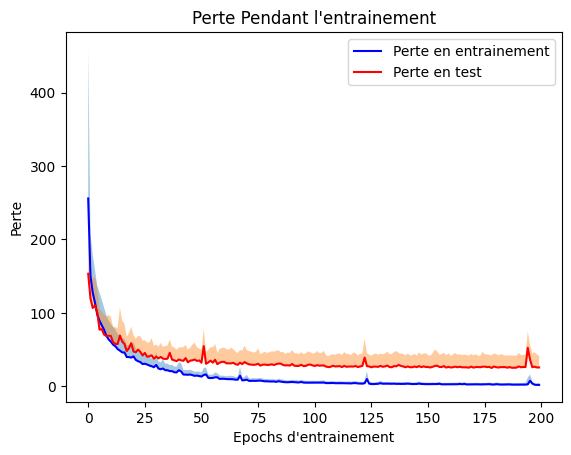

<Figure size 640x480 with 0 Axes>

In [10]:
# visualisation
display_graph_learning(hist_train_loss[:, 0], hist_val_loss[:, 0], hist_train_loss[:, 1], hist_val_loss[:, 1], "Perte Pendant l'entrainement", do_save=True, file_name='graph_epoch_selection')

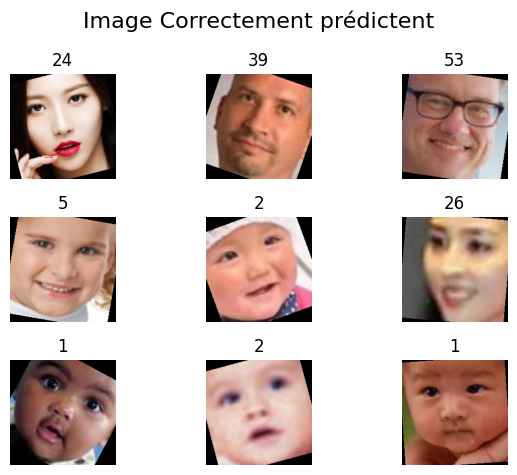

In [9]:
grid_image_data_set(results['images_correct'][:9], results['label_correct'][:9],"Image Correctement prédictent")

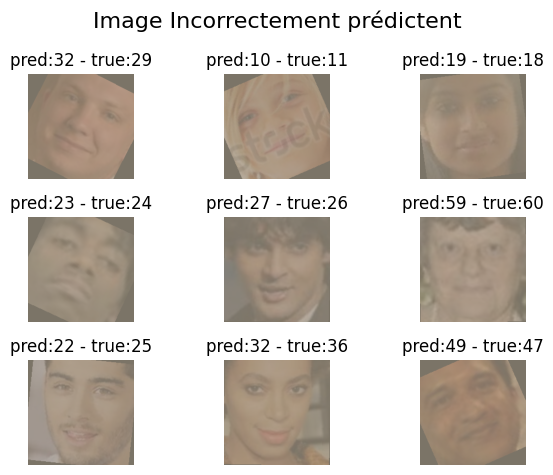

In [13]:
grid_image_data_set(results['images_incorrect'][:9], results['label_incorrect'][:9], "Image Incorrectement prédictent")

## Entrainement Complete Regression

In [6]:
faceDataset = FaceDataset(preprocess(), is_classification=False)
train_sampler, validation_sampler, test_sampler = train_validation_test_split(faceDataset, test_size=0.2)

### Entrainement avec l'hypothese des poids

In [5]:
# make ce
batch_size=32
learning_rate=1e-4


criterion = nn.MSELoss()

model_freeze_pretrain = ResnetCustomModel(pretrain=pretrain, is_freeze_pretrain=True)

optimizer = Adam(params=model_freeze_pretrain.parameters(), lr=learning_rate)


train_loader = DataLoader(faceDataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(faceDataset, batch_size=batch_size, sampler=test_sampler)


model_freeze_pretrain, hist_train_loss_model_freeze = training(model_freeze_pretrain, 125, criterion=criterion, optimizer=optimizer, 
                                                    train_loader=train_loader, 
                                                    full_train=True,
                                                    do_save=True,
                                                    file_name='restnet_custom_freeze_weight',
                                                    DEVICE='cuda')

Training process epoch 1/125


100%|██████████| 1082/1082 [07:42<00:00,  2.34it/s]


[-] epoch 1/125, train loss 223.489036
 
Training process epoch 2/125


100%|██████████| 1082/1082 [06:44<00:00,  2.68it/s]


[-] epoch 2/125, train loss 128.719072
 
Training process epoch 3/125


100%|██████████| 1082/1082 [07:20<00:00,  2.46it/s]


[-] epoch 3/125, train loss 106.943781
 
Training process epoch 4/125


100%|██████████| 1082/1082 [07:34<00:00,  2.38it/s]


[-] epoch 4/125, train loss 90.671845
 
Training process epoch 5/125


100%|██████████| 1082/1082 [07:35<00:00,  2.37it/s]


[-] epoch 5/125, train loss 83.358033
 
Training process epoch 6/125


100%|██████████| 1082/1082 [07:31<00:00,  2.40it/s]


[-] epoch 6/125, train loss 73.414353
 
Training process epoch 7/125


100%|██████████| 1082/1082 [07:07<00:00,  2.53it/s]


[-] epoch 7/125, train loss 69.953184
 
Training process epoch 8/125


100%|██████████| 1082/1082 [06:51<00:00,  2.63it/s]


[-] epoch 8/125, train loss 62.280553
 
Training process epoch 9/125


100%|██████████| 1082/1082 [06:55<00:00,  2.61it/s]


[-] epoch 9/125, train loss 57.493475
 
Training process epoch 10/125


100%|██████████| 1082/1082 [06:58<00:00,  2.59it/s]


[-] epoch 10/125, train loss 53.964198
 
Training process epoch 11/125


100%|██████████| 1082/1082 [06:44<00:00,  2.68it/s]


[-] epoch 11/125, train loss 51.670087
 
Training process epoch 12/125


100%|██████████| 1082/1082 [06:42<00:00,  2.69it/s]


[-] epoch 12/125, train loss 51.195652
 
Training process epoch 13/125


100%|██████████| 1082/1082 [07:03<00:00,  2.55it/s]


[-] epoch 13/125, train loss 46.637678
 
Training process epoch 14/125


100%|██████████| 1082/1082 [06:57<00:00,  2.59it/s]


[-] epoch 14/125, train loss 42.219577
 
Training process epoch 15/125


100%|██████████| 1082/1082 [06:58<00:00,  2.58it/s]


[-] epoch 15/125, train loss 41.889368
 
Training process epoch 16/125


100%|██████████| 1082/1082 [07:06<00:00,  2.54it/s]


[-] epoch 16/125, train loss 40.101705
 
Training process epoch 17/125


100%|██████████| 1082/1082 [07:23<00:00,  2.44it/s]


[-] epoch 17/125, train loss 37.939491
 
Training process epoch 18/125


100%|██████████| 1082/1082 [07:13<00:00,  2.49it/s]


[-] epoch 18/125, train loss 35.727846
 
Training process epoch 19/125


100%|██████████| 1082/1082 [07:01<00:00,  2.57it/s]


[-] epoch 19/125, train loss 36.576219
 
Training process epoch 20/125


100%|██████████| 1082/1082 [06:57<00:00,  2.59it/s]


[-] epoch 20/125, train loss 36.239332
 
Training process epoch 21/125


100%|██████████| 1082/1082 [06:43<00:00,  2.68it/s]


[-] epoch 21/125, train loss 32.762101
 
Training process epoch 22/125


100%|██████████| 1082/1082 [06:43<00:00,  2.68it/s]


[-] epoch 22/125, train loss 30.172498
 
Training process epoch 23/125


100%|██████████| 1082/1082 [06:45<00:00,  2.67it/s]


[-] epoch 23/125, train loss 29.044113
 
Training process epoch 24/125


100%|██████████| 1082/1082 [06:55<00:00,  2.60it/s]


[-] epoch 24/125, train loss 29.013431
 
Training process epoch 25/125


100%|██████████| 1082/1082 [06:49<00:00,  2.64it/s]


[-] epoch 25/125, train loss 27.524177
 
Training process epoch 26/125


100%|██████████| 1082/1082 [06:53<00:00,  2.62it/s]


[-] epoch 26/125, train loss 25.885719
 
Training process epoch 27/125


100%|██████████| 1082/1082 [06:56<00:00,  2.60it/s]


[-] epoch 27/125, train loss 25.531183
 
Training process epoch 28/125


100%|██████████| 1082/1082 [07:33<00:00,  2.39it/s]


[-] epoch 28/125, train loss 23.404551
 
Training process epoch 29/125


100%|██████████| 1082/1082 [07:30<00:00,  2.40it/s]


[-] epoch 29/125, train loss 24.712656
 
Training process epoch 30/125


100%|██████████| 1082/1082 [07:01<00:00,  2.57it/s]


[-] epoch 30/125, train loss 24.550320
 
Training process epoch 31/125


100%|██████████| 1082/1082 [09:04<00:00,  1.99it/s]


[-] epoch 31/125, train loss 20.779693
 
Training process epoch 32/125


100%|██████████| 1082/1082 [07:49<00:00,  2.31it/s]


[-] epoch 32/125, train loss 20.359412
 
Training process epoch 33/125


100%|██████████| 1082/1082 [06:42<00:00,  2.69it/s]


[-] epoch 33/125, train loss 23.768658
 
Training process epoch 34/125


100%|██████████| 1082/1082 [07:24<00:00,  2.44it/s]


[-] epoch 34/125, train loss 18.728549
 
Training process epoch 35/125


100%|██████████| 1082/1082 [07:20<00:00,  2.46it/s]


[-] epoch 35/125, train loss 19.983693
 
Training process epoch 36/125


100%|██████████| 1082/1082 [07:21<00:00,  2.45it/s]


[-] epoch 36/125, train loss 17.572512
 
Training process epoch 37/125


100%|██████████| 1082/1082 [06:54<00:00,  2.61it/s]


[-] epoch 37/125, train loss 18.061074
 
Training process epoch 38/125


100%|██████████| 1082/1082 [06:42<00:00,  2.69it/s]


[-] epoch 38/125, train loss 17.212359
 
Training process epoch 39/125


100%|██████████| 1082/1082 [07:35<00:00,  2.37it/s]


[-] epoch 39/125, train loss 17.952391
 
Training process epoch 40/125


100%|██████████| 1082/1082 [08:25<00:00,  2.14it/s]


[-] epoch 40/125, train loss 16.480315
 
Training process epoch 41/125


100%|██████████| 1082/1082 [07:15<00:00,  2.48it/s]


[-] epoch 41/125, train loss 15.372885
 
Training process epoch 42/125


100%|██████████| 1082/1082 [07:19<00:00,  2.46it/s]


[-] epoch 42/125, train loss 15.017222
 
Training process epoch 43/125


100%|██████████| 1082/1082 [06:59<00:00,  2.58it/s]


[-] epoch 43/125, train loss 15.278741
 
Training process epoch 44/125


100%|██████████| 1082/1082 [06:48<00:00,  2.65it/s]


[-] epoch 44/125, train loss 14.389167
 
Training process epoch 45/125


100%|██████████| 1082/1082 [06:57<00:00,  2.59it/s]


[-] epoch 45/125, train loss 13.572741
 
Training process epoch 46/125


100%|██████████| 1082/1082 [07:12<00:00,  2.50it/s]


[-] epoch 46/125, train loss 12.636378
 
Training process epoch 47/125


100%|██████████| 1082/1082 [06:56<00:00,  2.60it/s]


[-] epoch 47/125, train loss 14.157283
 
Training process epoch 48/125


100%|██████████| 1082/1082 [07:06<00:00,  2.54it/s]


[-] epoch 48/125, train loss 12.285564
 
Training process epoch 49/125


100%|██████████| 1082/1082 [07:05<00:00,  2.54it/s]


[-] epoch 49/125, train loss 12.010835
 
Training process epoch 50/125


100%|██████████| 1082/1082 [07:00<00:00,  2.57it/s]


[-] epoch 50/125, train loss 11.581581
 
Training process epoch 51/125


100%|██████████| 1082/1082 [07:04<00:00,  2.55it/s]


[-] epoch 51/125, train loss 13.422999
 
Training process epoch 52/125


100%|██████████| 1082/1082 [07:01<00:00,  2.56it/s]


[-] epoch 52/125, train loss 10.883585
 
Training process epoch 53/125


100%|██████████| 1082/1082 [07:05<00:00,  2.54it/s]


[-] epoch 53/125, train loss 10.294298
 
Training process epoch 54/125


100%|██████████| 1082/1082 [07:02<00:00,  2.56it/s]


[-] epoch 54/125, train loss 10.581922
 
Training process epoch 55/125


100%|██████████| 1082/1082 [07:00<00:00,  2.57it/s]


[-] epoch 55/125, train loss 10.411637
 
Training process epoch 56/125


100%|██████████| 1082/1082 [06:56<00:00,  2.60it/s]


[-] epoch 56/125, train loss 9.532426
 
Training process epoch 57/125


100%|██████████| 1082/1082 [07:09<00:00,  2.52it/s]


[-] epoch 57/125, train loss 9.797487
 
Training process epoch 58/125


100%|██████████| 1082/1082 [07:00<00:00,  2.57it/s]


[-] epoch 58/125, train loss 9.377609
 
Training process epoch 59/125


100%|██████████| 1082/1082 [07:16<00:00,  2.48it/s]


[-] epoch 59/125, train loss 8.902220
 
Training process epoch 60/125


100%|██████████| 1082/1082 [07:09<00:00,  2.52it/s]


[-] epoch 60/125, train loss 8.747673
 
Training process epoch 61/125


100%|██████████| 1082/1082 [07:06<00:00,  2.54it/s]


[-] epoch 61/125, train loss 10.149826
 
Training process epoch 62/125


100%|██████████| 1082/1082 [07:08<00:00,  2.52it/s]


[-] epoch 62/125, train loss 8.115524
 
Training process epoch 63/125


100%|██████████| 1082/1082 [07:06<00:00,  2.54it/s]


[-] epoch 63/125, train loss 9.407246
 
Training process epoch 64/125


100%|██████████| 1082/1082 [06:49<00:00,  2.64it/s]


[-] epoch 64/125, train loss 7.654487
 
Training process epoch 65/125


100%|██████████| 1082/1082 [06:53<00:00,  2.62it/s]


[-] epoch 65/125, train loss 7.509787
 
Training process epoch 66/125


100%|██████████| 1082/1082 [07:08<00:00,  2.53it/s]


[-] epoch 66/125, train loss 7.819540
 
Training process epoch 67/125


100%|██████████| 1082/1082 [07:07<00:00,  2.53it/s]


[-] epoch 67/125, train loss 7.495130
 
Training process epoch 68/125


100%|██████████| 1082/1082 [07:21<00:00,  2.45it/s]


[-] epoch 68/125, train loss 7.244815
 
Training process epoch 69/125


100%|██████████| 1082/1082 [07:08<00:00,  2.53it/s]


[-] epoch 69/125, train loss 7.189337
 
Training process epoch 70/125


100%|██████████| 1082/1082 [07:08<00:00,  2.52it/s]


[-] epoch 70/125, train loss 7.476566
 
Training process epoch 71/125


100%|██████████| 1082/1082 [07:07<00:00,  2.53it/s]


[-] epoch 71/125, train loss 6.842116
 
Training process epoch 72/125


100%|██████████| 1082/1082 [06:59<00:00,  2.58it/s]


[-] epoch 72/125, train loss 6.887909
 
Training process epoch 73/125


100%|██████████| 1082/1082 [07:06<00:00,  2.54it/s]


[-] epoch 73/125, train loss 6.567545
 
Training process epoch 74/125


100%|██████████| 1082/1082 [06:58<00:00,  2.59it/s]


[-] epoch 74/125, train loss 6.384045
 
Training process epoch 75/125


100%|██████████| 1082/1082 [06:59<00:00,  2.58it/s]


[-] epoch 75/125, train loss 7.390760
 
Training process epoch 76/125


100%|██████████| 1082/1082 [06:52<00:00,  2.62it/s]


[-] epoch 76/125, train loss 5.987073
 
Training process epoch 77/125


100%|██████████| 1082/1082 [07:03<00:00,  2.56it/s]


[-] epoch 77/125, train loss 5.641659
 
Training process epoch 78/125


100%|██████████| 1082/1082 [07:07<00:00,  2.53it/s]


[-] epoch 78/125, train loss 5.972164
 
Training process epoch 79/125


100%|██████████| 1082/1082 [07:38<00:00,  2.36it/s]


[-] epoch 79/125, train loss 5.845658
 
Training process epoch 80/125


100%|██████████| 1082/1082 [07:16<00:00,  2.48it/s]


[-] epoch 80/125, train loss 5.811232
 
Training process epoch 81/125


100%|██████████| 1082/1082 [07:17<00:00,  2.47it/s]


[-] epoch 81/125, train loss 5.583966
 
Training process epoch 82/125


100%|██████████| 1082/1082 [07:12<00:00,  2.50it/s]


[-] epoch 82/125, train loss 5.680357
 
Training process epoch 83/125


100%|██████████| 1082/1082 [07:31<00:00,  2.39it/s]


[-] epoch 83/125, train loss 5.492621
 
Training process epoch 84/125


100%|██████████| 1082/1082 [07:11<00:00,  2.51it/s]


[-] epoch 84/125, train loss 6.346880
 
Training process epoch 85/125


100%|██████████| 1082/1082 [07:12<00:00,  2.50it/s]


[-] epoch 85/125, train loss 5.212484
 
Training process epoch 86/125


100%|██████████| 1082/1082 [07:15<00:00,  2.48it/s]


[-] epoch 86/125, train loss 4.821726
 
Training process epoch 87/125


100%|██████████| 1082/1082 [07:35<00:00,  2.38it/s]


[-] epoch 87/125, train loss 4.866529
 
Training process epoch 88/125


100%|██████████| 1082/1082 [08:01<00:00,  2.25it/s]


[-] epoch 88/125, train loss 4.952074
 
Training process epoch 89/125


100%|██████████| 1082/1082 [08:47<00:00,  2.05it/s]


[-] epoch 89/125, train loss 4.981373
 
Training process epoch 90/125


100%|██████████| 1082/1082 [07:44<00:00,  2.33it/s]


[-] epoch 90/125, train loss 4.961045
 
Training process epoch 91/125


100%|██████████| 1082/1082 [07:34<00:00,  2.38it/s]


[-] epoch 91/125, train loss 4.796363
 
Training process epoch 92/125


100%|██████████| 1082/1082 [07:55<00:00,  2.27it/s]


[-] epoch 92/125, train loss 5.348517
 
Training process epoch 93/125


100%|██████████| 1082/1082 [07:41<00:00,  2.35it/s]


[-] epoch 93/125, train loss 4.710777
 
Training process epoch 94/125


100%|██████████| 1082/1082 [07:44<00:00,  2.33it/s]


[-] epoch 94/125, train loss 4.471084
 
Training process epoch 95/125


100%|██████████| 1082/1082 [07:39<00:00,  2.35it/s]


[-] epoch 95/125, train loss 4.733701
 
Training process epoch 96/125


100%|██████████| 1082/1082 [07:46<00:00,  2.32it/s]


[-] epoch 96/125, train loss 4.604766
 
Training process epoch 97/125


100%|██████████| 1082/1082 [07:43<00:00,  2.33it/s]


[-] epoch 97/125, train loss 4.349727
 
Training process epoch 98/125


100%|██████████| 1082/1082 [07:40<00:00,  2.35it/s]


[-] epoch 98/125, train loss 4.438877
 
Training process epoch 99/125


100%|██████████| 1082/1082 [07:51<00:00,  2.30it/s]


[-] epoch 99/125, train loss 4.562786
 
Training process epoch 100/125


100%|██████████| 1082/1082 [07:54<00:00,  2.28it/s]


[-] epoch 100/125, train loss 5.521339
 
Training process epoch 101/125


100%|██████████| 1082/1082 [07:43<00:00,  2.33it/s]


[-] epoch 101/125, train loss 7.588693
 
Training process epoch 102/125


100%|██████████| 1082/1082 [07:42<00:00,  2.34it/s]


[-] epoch 102/125, train loss 5.099982
 
Training process epoch 103/125


100%|██████████| 1082/1082 [07:40<00:00,  2.35it/s]


[-] epoch 103/125, train loss 3.612738
 
Training process epoch 104/125


100%|██████████| 1082/1082 [07:46<00:00,  2.32it/s]


[-] epoch 104/125, train loss 3.720912
 
Training process epoch 105/125


100%|██████████| 1082/1082 [07:35<00:00,  2.38it/s]


[-] epoch 105/125, train loss 3.763033
 
Training process epoch 106/125


100%|██████████| 1082/1082 [07:35<00:00,  2.37it/s]


[-] epoch 106/125, train loss 3.840601
 
Training process epoch 107/125


100%|██████████| 1082/1082 [07:39<00:00,  2.36it/s]


[-] epoch 107/125, train loss 3.981750
 
Training process epoch 108/125


100%|██████████| 1082/1082 [07:44<00:00,  2.33it/s]


[-] epoch 108/125, train loss 4.036248
 
Training process epoch 109/125


100%|██████████| 1082/1082 [07:44<00:00,  2.33it/s]


[-] epoch 109/125, train loss 3.838289
 
Training process epoch 110/125


100%|██████████| 1082/1082 [07:47<00:00,  2.31it/s]


[-] epoch 110/125, train loss 3.928859
 
Training process epoch 111/125


100%|██████████| 1082/1082 [07:42<00:00,  2.34it/s]


[-] epoch 111/125, train loss 3.961993
 
Training process epoch 112/125


100%|██████████| 1082/1082 [07:44<00:00,  2.33it/s]


[-] epoch 112/125, train loss 6.248054
 
Training process epoch 113/125


100%|██████████| 1082/1082 [07:46<00:00,  2.32it/s]


[-] epoch 113/125, train loss 3.425239
 
Training process epoch 114/125


100%|██████████| 1082/1082 [07:11<00:00,  2.50it/s]


[-] epoch 114/125, train loss 3.121349
 
Training process epoch 115/125


100%|██████████| 1082/1082 [06:55<00:00,  2.61it/s]


[-] epoch 115/125, train loss 3.417515
 
Training process epoch 116/125


100%|██████████| 1082/1082 [07:44<00:00,  2.33it/s]


[-] epoch 116/125, train loss 3.406154
 
Training process epoch 117/125


100%|██████████| 1082/1082 [08:07<00:00,  2.22it/s]


[-] epoch 117/125, train loss 3.602492
 
Training process epoch 118/125


100%|██████████| 1082/1082 [06:45<00:00,  2.67it/s]


[-] epoch 118/125, train loss 3.480963
 
Training process epoch 119/125


100%|██████████| 1082/1082 [07:55<00:00,  2.28it/s]


[-] epoch 119/125, train loss 3.713930
 
Training process epoch 120/125


100%|██████████| 1082/1082 [08:03<00:00,  2.24it/s]


[-] epoch 120/125, train loss 3.733499
 
Training process epoch 121/125


100%|██████████| 1082/1082 [08:10<00:00,  2.21it/s]


[-] epoch 121/125, train loss 3.476842
 
Training process epoch 122/125


100%|██████████| 1082/1082 [08:03<00:00,  2.24it/s]


[-] epoch 122/125, train loss 3.290067
 
Training process epoch 123/125


100%|██████████| 1082/1082 [08:04<00:00,  2.24it/s]


[-] epoch 123/125, train loss 3.903578
 
Training process epoch 124/125


100%|██████████| 1082/1082 [08:03<00:00,  2.24it/s]


[-] epoch 124/125, train loss 3.528497
 
Training process epoch 125/125


100%|██████████| 1082/1082 [08:04<00:00,  2.24it/s]

[-] epoch 125/125, train loss 3.149123
 


ValueError: too many values to unpack (expected 3)

In [6]:
model_freeze_pretrain = torch.load('models/restnet_custom_freeze_weight.pt')

### Test

In [7]:
# batch_size=64
# test_loader = DataLoader(faceDataset, batch_size=batch_size, sampler=test_sampler)
# make test
results, y_pred, y_true = testing(model_freeze_pretrain, criterion, test_validation=test_loader, DEVICE='cuda')

Test: 100%|██████████| 271/271 [00:57<00:00,  4.69it/s]

[-] Test loss 24.261017


In [8]:
matrix, scores_ensemble, roc_plot = scores(y_true=y_true, y_pred=y_pred, is_classification=False)
scores_ensemble

,MAE,error
0,2.707616,0.951679


### Visualisation des données et discussion

In [ ]:
# visualisation
display_graph_learning(hist_train_loss[:, 0], hist_val_loss[:, 0], hist_train_loss[:, 1], hist_val_loss[:, 1], "Perte Pendant l'entrainement")

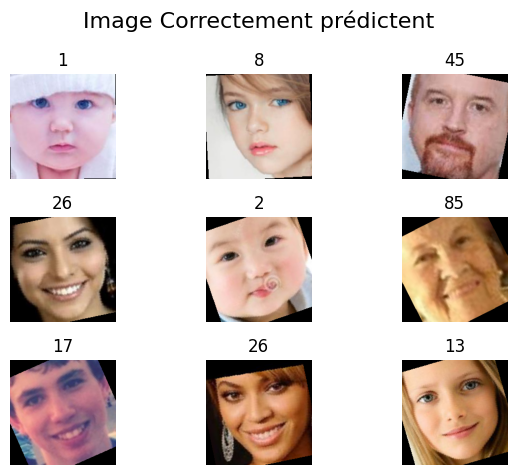

In [10]:
grid_image_data_set(results['images_correct'][:9], results['label_correct'][:9],"Image Correctement prédictent")

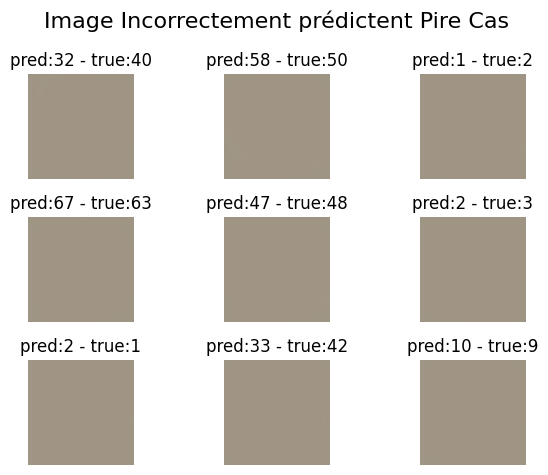

In [23]:
grid_image_data_set(results['images_incorrect'][:9], results['label_incorrect'][:9], "Image Incorrectement prédictent Pire Cas")

In [7]:
# make ce
batch_size=32
learning_rate=1e-4


criterion = nn.MSELoss()

model_simple = ResnetCustomModel()

optimizer = Adam(params=model_simple.parameters(), lr=learning_rate)


train_loader = DataLoader(faceDataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(faceDataset, batch_size=batch_size, sampler=test_sampler)


model_simple, hist_train_loss, hist_val_loss, _ = training(model_simple, 125, criterion=criterion, optimizer=optimizer, 
                                                    train_loader=train_loader, 
                                                    full_train=True,
                                                    do_save=True,
                                                    file_name=f'resnet_custom_simple', 
                                                    DEVICE='cuda')

Training process epoch 1/125


100%|██████████| 1082/1082 [08:27<00:00,  2.13it/s]


[-] epoch 1/125, train loss 264.804910
 
Training process epoch 2/125


100%|██████████| 1082/1082 [08:28<00:00,  2.13it/s]


[-] epoch 2/125, train loss 137.683411
 
Training process epoch 3/125


100%|██████████| 1082/1082 [08:23<00:00,  2.15it/s]


[-] epoch 3/125, train loss 110.533719
 
Training process epoch 4/125


100%|██████████| 1082/1082 [08:25<00:00,  2.14it/s]


[-] epoch 4/125, train loss 95.332493
 
Training process epoch 5/125


100%|██████████| 1082/1082 [08:26<00:00,  2.14it/s]


[-] epoch 5/125, train loss 85.699533
 
Training process epoch 6/125


100%|██████████| 1082/1082 [08:26<00:00,  2.13it/s]


[-] epoch 6/125, train loss 77.856294
 
Training process epoch 7/125


100%|██████████| 1082/1082 [08:25<00:00,  2.14it/s]


[-] epoch 7/125, train loss 69.678090
 
Training process epoch 8/125


100%|██████████| 1082/1082 [08:25<00:00,  2.14it/s]


[-] epoch 8/125, train loss 66.521657
 
Training process epoch 9/125


100%|██████████| 1082/1082 [08:25<00:00,  2.14it/s]


[-] epoch 9/125, train loss 63.087650
 
Training process epoch 10/125


100%|██████████| 1082/1082 [08:24<00:00,  2.14it/s]


[-] epoch 10/125, train loss 58.066978
 
Training process epoch 11/125


100%|██████████| 1082/1082 [08:25<00:00,  2.14it/s]


[-] epoch 11/125, train loss 54.238018
 
Training process epoch 12/125


100%|██████████| 1082/1082 [08:27<00:00,  2.13it/s]


[-] epoch 12/125, train loss 50.748810
 
Training process epoch 13/125


100%|██████████| 1082/1082 [08:27<00:00,  2.13it/s]


[-] epoch 13/125, train loss 49.082911
 
Training process epoch 14/125


100%|██████████| 1082/1082 [08:27<00:00,  2.13it/s]


[-] epoch 14/125, train loss 46.093809
 
Training process epoch 15/125


100%|██████████| 1082/1082 [08:28<00:00,  2.13it/s]


[-] epoch 15/125, train loss 43.922235
 
Training process epoch 16/125


100%|██████████| 1082/1082 [08:29<00:00,  2.12it/s]


[-] epoch 16/125, train loss 43.916167
 
Training process epoch 17/125


100%|██████████| 1082/1082 [08:26<00:00,  2.14it/s]


[-] epoch 17/125, train loss 39.226845
 
Training process epoch 18/125


100%|██████████| 1082/1082 [08:26<00:00,  2.14it/s]


[-] epoch 18/125, train loss 37.478854
 
Training process epoch 19/125


100%|██████████| 1082/1082 [08:27<00:00,  2.13it/s]


[-] epoch 19/125, train loss 36.637711
 
Training process epoch 20/125


100%|██████████| 1082/1082 [08:24<00:00,  2.14it/s]


[-] epoch 20/125, train loss 33.692149
 
Training process epoch 21/125


100%|██████████| 1082/1082 [08:24<00:00,  2.14it/s]


[-] epoch 21/125, train loss 33.219394
 
Training process epoch 22/125


100%|██████████| 1082/1082 [08:26<00:00,  2.14it/s]


[-] epoch 22/125, train loss 31.757502
 
Training process epoch 23/125


100%|██████████| 1082/1082 [08:26<00:00,  2.14it/s]


[-] epoch 23/125, train loss 30.514842
 
Training process epoch 24/125


100%|██████████| 1082/1082 [08:24<00:00,  2.14it/s]


[-] epoch 24/125, train loss 29.481419
 
Training process epoch 25/125


100%|██████████| 1082/1082 [08:25<00:00,  2.14it/s]


[-] epoch 25/125, train loss 27.501467
 
Training process epoch 26/125


100%|██████████| 1082/1082 [08:23<00:00,  2.15it/s]


[-] epoch 26/125, train loss 26.280291
 
Training process epoch 27/125


100%|██████████| 1082/1082 [08:24<00:00,  2.14it/s]


[-] epoch 27/125, train loss 25.784604
 
Training process epoch 28/125


100%|██████████| 1082/1082 [08:30<00:00,  2.12it/s]


[-] epoch 28/125, train loss 25.188454
 
Training process epoch 29/125


100%|██████████| 1082/1082 [08:28<00:00,  2.13it/s]


[-] epoch 29/125, train loss 23.887258
 
Training process epoch 30/125


100%|██████████| 1082/1082 [08:28<00:00,  2.13it/s]


[-] epoch 30/125, train loss 24.637646
 
Training process epoch 31/125


100%|██████████| 1082/1082 [08:29<00:00,  2.12it/s]


[-] epoch 31/125, train loss 21.646306
 
Training process epoch 32/125


100%|██████████| 1082/1082 [08:29<00:00,  2.12it/s]


[-] epoch 32/125, train loss 20.928036
 
Training process epoch 33/125


100%|██████████| 1082/1082 [08:29<00:00,  2.12it/s]


[-] epoch 33/125, train loss 21.543841
 
Training process epoch 34/125


100%|██████████| 1082/1082 [08:28<00:00,  2.13it/s]


[-] epoch 34/125, train loss 20.471252
 
Training process epoch 35/125


100%|██████████| 1082/1082 [08:29<00:00,  2.12it/s]


[-] epoch 35/125, train loss 19.004119
 
Training process epoch 36/125


100%|██████████| 1082/1082 [08:28<00:00,  2.13it/s]


[-] epoch 36/125, train loss 19.038252
 
Training process epoch 37/125


100%|██████████| 1082/1082 [08:29<00:00,  2.12it/s]


[-] epoch 37/125, train loss 18.083776
 
Training process epoch 38/125


100%|██████████| 1082/1082 [08:30<00:00,  2.12it/s]


[-] epoch 38/125, train loss 18.212763
 
Training process epoch 39/125


100%|██████████| 1082/1082 [08:28<00:00,  2.13it/s]


[-] epoch 39/125, train loss 16.965250
 
Training process epoch 40/125


100%|██████████| 1082/1082 [08:28<00:00,  2.13it/s]


[-] epoch 40/125, train loss 16.526351
 
Training process epoch 41/125


100%|██████████| 1082/1082 [08:28<00:00,  2.13it/s]


[-] epoch 41/125, train loss 15.244291
 
Training process epoch 42/125


100%|██████████| 1082/1082 [08:29<00:00,  2.12it/s]


[-] epoch 42/125, train loss 16.153000
 
Training process epoch 43/125


100%|██████████| 1082/1082 [08:29<00:00,  2.12it/s]


[-] epoch 43/125, train loss 16.074769
 
Training process epoch 44/125


100%|██████████| 1082/1082 [08:30<00:00,  2.12it/s]


[-] epoch 44/125, train loss 14.719376
 
Training process epoch 45/125


100%|██████████| 1082/1082 [08:28<00:00,  2.13it/s]


[-] epoch 45/125, train loss 14.317122
 
Training process epoch 46/125


100%|██████████| 1082/1082 [08:28<00:00,  2.13it/s]


[-] epoch 46/125, train loss 13.718454
 
Training process epoch 47/125


100%|██████████| 1082/1082 [08:28<00:00,  2.13it/s]


[-] epoch 47/125, train loss 13.252411
 
Training process epoch 48/125


100%|██████████| 1082/1082 [08:28<00:00,  2.13it/s]


[-] epoch 48/125, train loss 13.049219
 
Training process epoch 49/125


100%|██████████| 1082/1082 [08:28<00:00,  2.13it/s]


[-] epoch 49/125, train loss 13.413266
 
Training process epoch 50/125


100%|██████████| 1082/1082 [08:28<00:00,  2.13it/s]


[-] epoch 50/125, train loss 12.374664
 
Training process epoch 51/125


100%|██████████| 1082/1082 [08:29<00:00,  2.12it/s]


[-] epoch 51/125, train loss 11.848580
 
Training process epoch 52/125


100%|██████████| 1082/1082 [08:28<00:00,  2.13it/s]


[-] epoch 52/125, train loss 12.102361
 
Training process epoch 53/125


100%|██████████| 1082/1082 [08:29<00:00,  2.12it/s]


[-] epoch 53/125, train loss 11.181894
 
Training process epoch 54/125


100%|██████████| 1082/1082 [08:28<00:00,  2.13it/s]


[-] epoch 54/125, train loss 11.336345
 
Training process epoch 55/125


100%|██████████| 1082/1082 [08:19<00:00,  2.17it/s]


[-] epoch 55/125, train loss 10.763631
 
Training process epoch 56/125


100%|██████████| 1082/1082 [08:18<00:00,  2.17it/s]


[-] epoch 56/125, train loss 10.475613
 
Training process epoch 57/125


100%|██████████| 1082/1082 [07:41<00:00,  2.34it/s]


[-] epoch 57/125, train loss 10.434505
 
Training process epoch 58/125


100%|██████████| 1082/1082 [07:36<00:00,  2.37it/s]


[-] epoch 58/125, train loss 10.708056
 
Training process epoch 59/125


100%|██████████| 1082/1082 [07:21<00:00,  2.45it/s]


[-] epoch 59/125, train loss 9.388972
 
Training process epoch 60/125


100%|██████████| 1082/1082 [07:00<00:00,  2.57it/s]


[-] epoch 60/125, train loss 9.919093
 
Training process epoch 61/125


100%|██████████| 1082/1082 [07:09<00:00,  2.52it/s]


[-] epoch 61/125, train loss 8.769246
 
Training process epoch 62/125


100%|██████████| 1082/1082 [07:26<00:00,  2.42it/s]


[-] epoch 62/125, train loss 9.009415
 
Training process epoch 63/125


100%|██████████| 1082/1082 [07:04<00:00,  2.55it/s]


[-] epoch 63/125, train loss 8.450317
 
Training process epoch 64/125


100%|██████████| 1082/1082 [07:02<00:00,  2.56it/s]


[-] epoch 64/125, train loss 9.016387
 
Training process epoch 65/125


100%|██████████| 1082/1082 [06:47<00:00,  2.65it/s]


[-] epoch 65/125, train loss 8.391833
 
Training process epoch 66/125


100%|██████████| 1082/1082 [06:51<00:00,  2.63it/s]


[-] epoch 66/125, train loss 8.108869
 
Training process epoch 67/125


100%|██████████| 1082/1082 [07:08<00:00,  2.53it/s]


[-] epoch 67/125, train loss 8.217453
 
Training process epoch 68/125


100%|██████████| 1082/1082 [07:03<00:00,  2.55it/s]


[-] epoch 68/125, train loss 7.861994
 
Training process epoch 69/125


100%|██████████| 1082/1082 [06:48<00:00,  2.65it/s]


[-] epoch 69/125, train loss 7.610796
 
Training process epoch 70/125


100%|██████████| 1082/1082 [07:09<00:00,  2.52it/s]


[-] epoch 70/125, train loss 7.425814
 
Training process epoch 71/125


100%|██████████| 1082/1082 [07:03<00:00,  2.55it/s]


[-] epoch 71/125, train loss 7.281242
 
Training process epoch 72/125


100%|██████████| 1082/1082 [07:06<00:00,  2.54it/s]


[-] epoch 72/125, train loss 7.186742
 
Training process epoch 73/125


100%|██████████| 1082/1082 [06:54<00:00,  2.61it/s]


[-] epoch 73/125, train loss 7.052787
 
Training process epoch 74/125


100%|██████████| 1082/1082 [06:52<00:00,  2.62it/s]


[-] epoch 74/125, train loss 7.321962
 
Training process epoch 75/125


100%|██████████| 1082/1082 [06:59<00:00,  2.58it/s]


[-] epoch 75/125, train loss 6.913802
 
Training process epoch 76/125


100%|██████████| 1082/1082 [06:57<00:00,  2.59it/s]


[-] epoch 76/125, train loss 6.343197
 
Training process epoch 77/125


100%|██████████| 1082/1082 [06:49<00:00,  2.64it/s]


[-] epoch 77/125, train loss 6.572076
 
Training process epoch 78/125


100%|██████████| 1082/1082 [06:57<00:00,  2.59it/s]


[-] epoch 78/125, train loss 6.593694
 
Training process epoch 79/125


100%|██████████| 1082/1082 [06:51<00:00,  2.63it/s]


[-] epoch 79/125, train loss 6.359881
 
Training process epoch 80/125


100%|██████████| 1082/1082 [06:53<00:00,  2.62it/s]


[-] epoch 80/125, train loss 6.094187
 
Training process epoch 81/125


100%|██████████| 1082/1082 [06:50<00:00,  2.63it/s]


[-] epoch 81/125, train loss 5.999447
 
Training process epoch 82/125


100%|██████████| 1082/1082 [06:50<00:00,  2.64it/s]


[-] epoch 82/125, train loss 5.997500
 
Training process epoch 83/125


100%|██████████| 1082/1082 [06:53<00:00,  2.61it/s]


[-] epoch 83/125, train loss 6.786700
 
Training process epoch 84/125


100%|██████████| 1082/1082 [06:55<00:00,  2.60it/s]


[-] epoch 84/125, train loss 5.475811
 
Training process epoch 85/125


100%|██████████| 1082/1082 [07:01<00:00,  2.57it/s]


[-] epoch 85/125, train loss 5.886216
 
Training process epoch 86/125


100%|██████████| 1082/1082 [08:07<00:00,  2.22it/s]


[-] epoch 86/125, train loss 5.660452
 
Training process epoch 87/125


100%|██████████| 1082/1082 [07:55<00:00,  2.27it/s]


[-] epoch 87/125, train loss 5.311752
 
Training process epoch 88/125


100%|██████████| 1082/1082 [07:32<00:00,  2.39it/s]


[-] epoch 88/125, train loss 5.164422
 
Training process epoch 89/125


100%|██████████| 1082/1082 [07:24<00:00,  2.44it/s]


[-] epoch 89/125, train loss 5.317761
 
Training process epoch 90/125


100%|██████████| 1082/1082 [07:10<00:00,  2.52it/s]


[-] epoch 90/125, train loss 5.168142
 
Training process epoch 91/125


100%|██████████| 1082/1082 [07:12<00:00,  2.50it/s]


[-] epoch 91/125, train loss 5.225589
 
Training process epoch 92/125


100%|██████████| 1082/1082 [07:18<00:00,  2.47it/s]


[-] epoch 92/125, train loss 4.948657
 
Training process epoch 93/125


100%|██████████| 1082/1082 [07:24<00:00,  2.44it/s]


[-] epoch 93/125, train loss 4.882791
 
Training process epoch 94/125


100%|██████████| 1082/1082 [07:33<00:00,  2.38it/s]


[-] epoch 94/125, train loss 4.823586
 
Training process epoch 95/125


100%|██████████| 1082/1082 [07:23<00:00,  2.44it/s]


[-] epoch 95/125, train loss 4.907672
 
Training process epoch 96/125


100%|██████████| 1082/1082 [07:06<00:00,  2.54it/s]


[-] epoch 96/125, train loss 4.597785
 
Training process epoch 97/125


100%|██████████| 1082/1082 [07:34<00:00,  2.38it/s]


[-] epoch 97/125, train loss 4.807030
 
Training process epoch 98/125


100%|██████████| 1082/1082 [07:12<00:00,  2.50it/s]


[-] epoch 98/125, train loss 5.811302
 
Training process epoch 99/125


100%|██████████| 1082/1082 [07:02<00:00,  2.56it/s]


[-] epoch 99/125, train loss 4.822052
 
Training process epoch 100/125


100%|██████████| 1082/1082 [07:22<00:00,  2.44it/s]


[-] epoch 100/125, train loss 4.204262
 
Training process epoch 101/125


100%|██████████| 1082/1082 [07:30<00:00,  2.40it/s]


[-] epoch 101/125, train loss 4.784118
 
Training process epoch 102/125


100%|██████████| 1082/1082 [07:30<00:00,  2.40it/s]


[-] epoch 102/125, train loss 4.377108
 
Training process epoch 103/125


100%|██████████| 1082/1082 [07:06<00:00,  2.54it/s]


[-] epoch 103/125, train loss 4.178587
 
Training process epoch 104/125


100%|██████████| 1082/1082 [06:53<00:00,  2.62it/s]


[-] epoch 104/125, train loss 4.322402
 
Training process epoch 105/125


100%|██████████| 1082/1082 [07:16<00:00,  2.48it/s]


[-] epoch 105/125, train loss 4.106846
 
Training process epoch 106/125


100%|██████████| 1082/1082 [07:27<00:00,  2.42it/s]


[-] epoch 106/125, train loss 4.177876
 
Training process epoch 107/125


100%|██████████| 1082/1082 [07:41<00:00,  2.34it/s]


[-] epoch 107/125, train loss 7.487269
 
Training process epoch 108/125


100%|██████████| 1082/1082 [09:00<00:00,  2.00it/s]


[-] epoch 108/125, train loss 4.212935
 
Training process epoch 109/125


100%|██████████| 1082/1082 [07:34<00:00,  2.38it/s]


[-] epoch 109/125, train loss 3.409211
 
Training process epoch 110/125


100%|██████████| 1082/1082 [07:08<00:00,  2.53it/s]


[-] epoch 110/125, train loss 3.671453
 
Training process epoch 111/125


100%|██████████| 1082/1082 [07:09<00:00,  2.52it/s]


[-] epoch 111/125, train loss 3.838289
 
Training process epoch 112/125


100%|██████████| 1082/1082 [07:15<00:00,  2.49it/s]


[-] epoch 112/125, train loss 4.169437
 
Training process epoch 113/125


100%|██████████| 1082/1082 [07:16<00:00,  2.48it/s]


[-] epoch 113/125, train loss 3.746888
 
Training process epoch 114/125


100%|██████████| 1082/1082 [07:17<00:00,  2.47it/s]


[-] epoch 114/125, train loss 3.801647
 
Training process epoch 115/125


100%|██████████| 1082/1082 [07:21<00:00,  2.45it/s]


[-] epoch 115/125, train loss 4.053173
 
Training process epoch 116/125


100%|██████████| 1082/1082 [07:17<00:00,  2.47it/s]


[-] epoch 116/125, train loss 3.646042
 
Training process epoch 117/125


100%|██████████| 1082/1082 [07:43<00:00,  2.33it/s]


[-] epoch 117/125, train loss 4.761063
 
Training process epoch 118/125


100%|██████████| 1082/1082 [07:24<00:00,  2.43it/s]


[-] epoch 118/125, train loss 3.508152
 
Training process epoch 119/125


100%|██████████| 1082/1082 [07:13<00:00,  2.50it/s]


[-] epoch 119/125, train loss 3.386036
 
Training process epoch 120/125


100%|██████████| 1082/1082 [07:33<00:00,  2.39it/s]


[-] epoch 120/125, train loss 3.636982
 
Training process epoch 121/125


100%|██████████| 1082/1082 [06:53<00:00,  2.62it/s]


[-] epoch 121/125, train loss 3.701494
 
Training process epoch 122/125


100%|██████████| 1082/1082 [07:14<00:00,  2.49it/s]


[-] epoch 122/125, train loss 3.915569
 
Training process epoch 123/125


100%|██████████| 1082/1082 [07:21<00:00,  2.45it/s]


[-] epoch 123/125, train loss 3.519528
 
Training process epoch 124/125


100%|██████████| 1082/1082 [07:31<00:00,  2.40it/s]


[-] epoch 124/125, train loss 3.297083
 
Training process epoch 125/125


100%|██████████| 1082/1082 [07:27<00:00,  2.42it/s]

[-] epoch 125/125, train loss 3.427756
 


In [9]:
results, y_pred, y_true = testing(model_simple, criterion, test_validation=test_loader, DEVICE='cuda')

Test: 100%|██████████| 271/271 [01:06<00:00,  4.09it/s]

[-] Test loss 25.069410


In [13]:
matrix, scores_ensemble, roc_plot = scores(y_true=y_true, y_pred=y_pred, is_classification=False)
scores_ensemble

,MAE,error
0,2.697099,0.949933


974 min

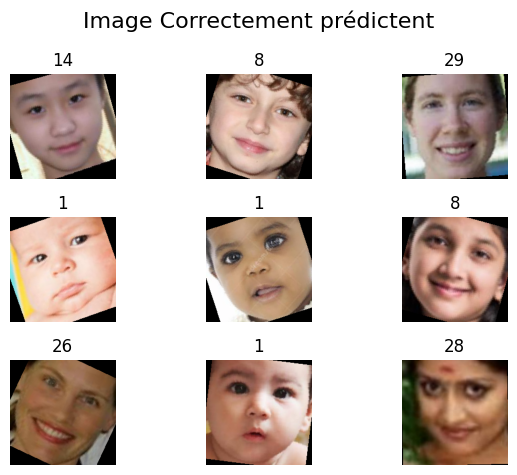

In [11]:
grid_image_data_set(results['images_correct'][:9], results['label_correct'][:9],"Image Correctement prédictent")

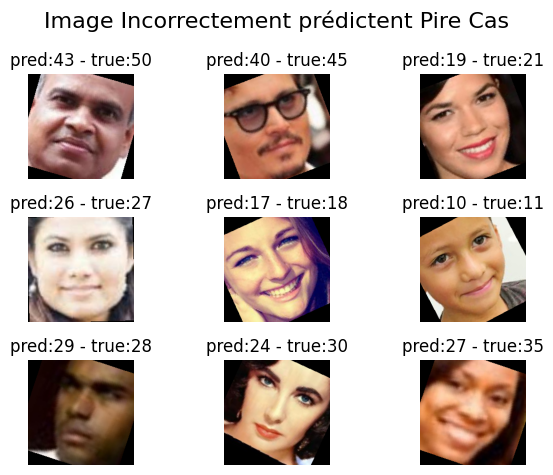

In [12]:
grid_image_data_set(results['images_incorrect'][:9], results['label_incorrect'][:9], "Image Incorrectement prédictent Pire Cas")

## Classification Resnet Custom

In [ ]:
faceDataset = FaceDataset(preprocess(), is_classification=True)

### Entrainement

In [ ]:
# make training

### Test

In [ ]:
# make test

### Visualisation des données et discussion

In [ ]:
# visualisation